# **Predictive Analytics: Amazon Sales Forecasting Model**
## Individual Assignment
### Candidate Number: NMZR2



# Data Processes

In [ ]:
!pip install category_encoders

## Import Packages

In [ ]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

## Retrieve Data Set

In [ ]:
# Read Data Set

from google.colab import drive

drive.mount('/content/drive')

# Specify the full path to your CSV file in the shared drive
file_path = '/content/drive/MyDrive/MBAn/Predictive Analytics/amazon-purchases.csv'  # Replace with the actual path
try:
  df = pd.read_csv(file_path)
  print("DataFrame loaded successfully.")
  print(df.head())
except FileNotFoundError:
  print(f"Error: File not found at {file_path}")
except pd.errors.EmptyDataError:
  print(f"Error: The file at {file_path} is empty.")
except pd.errors.ParserError:
  print(f"Error: Unable to parse the file at {file_path}. Check the file format.")
except Exception as e:
  print(f"An unexpected error occurred: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DataFrame loaded successfully.
   Order Date  Purchase Price Per Unit  Quantity Shipping Address State  \
0  2018-12-04                     7.98       1.0                     NJ   
1  2018-12-22                    13.99       1.0                     NJ   
2  2018-12-24                     8.99       1.0                     NJ   
3  2018-12-25                    10.45       1.0                     NJ   
4  2018-12-25                    10.00       1.0                     NJ   

                                               Title ASIN/ISBN (Product Code)  \
0  SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...               B0143RTB1E   
1  Betron BS10 Earphones Wired Headphones in Ear ...               B01MA1MJ6H   
2                                                NaN               B078JZTFN3   
3  Perfecto Stainless Steel Shaving Bowl. Durable...             

# Explotarory Data Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1850717 entries, 0 to 1850716
Data columns (total 8 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   Order Date                object 
 1   Purchase Price Per Unit   float64
 2   Quantity                  float64
 3   Shipping Address State    object 
 4   Title                     object 
 5   ASIN/ISBN (Product Code)  object 
 6   Category                  object 
 7   Survey ResponseID         object 
dtypes: float64(2), object(6)
memory usage: 113.0+ MB


In [ ]:
df.head()

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Category,Survey ResponseID
0,2018-12-04,7.98,1.0,NJ,SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...,B0143RTB1E,FLASH_MEMORY,R_01vNIayewjIIKMF
1,2018-12-22,13.99,1.0,NJ,Betron BS10 Earphones Wired Headphones in Ear ...,B01MA1MJ6H,HEADPHONES,R_01vNIayewjIIKMF
2,2018-12-24,8.99,1.0,NJ,NaN,B078JZTFN3,NaN,R_01vNIayewjIIKMF
3,2018-12-25,10.45,1.0,NJ,Perfecto Stainless Steel Shaving Bowl. Durable...,B06XWF9HML,DISHWARE_BOWL,R_01vNIayewjIIKMF
4,2018-12-25,10.00,1.0,NJ,Proraso Shaving Cream for Men,B00837ZOI0,SHAVING_AGENT,R_01vNIayewjIIKMF


In [ ]:
#Simplfy and rename columns
new_column_names = {
      'ASIN/ISBN (Product Code)': 'Product Code',
      'Purchase Price Per Unit': 'Price Per Unit',
      'Shipping Address State': 'Shipping Address',
      'Survey ResponseID': 'Survey ID'
  }
df = df.rename(columns=new_column_names)

df.head()

,Order Date,Price Per Unit,Quantity,Shipping Address,Title,Product Code,Category,Survey ID
0,2018-12-04,7.98,1.0,NJ,SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...,B0143RTB1E,FLASH_MEMORY,R_01vNIayewjIIKMF
1,2018-12-22,13.99,1.0,NJ,Betron BS10 Earphones Wired Headphones in Ear ...,B01MA1MJ6H,HEADPHONES,R_01vNIayewjIIKMF
2,2018-12-24,8.99,1.0,NJ,NaN,B078JZTFN3,NaN,R_01vNIayewjIIKMF
3,2018-12-25,10.45,1.0,NJ,Perfecto Stainless Steel Shaving Bowl. Durable...,B06XWF9HML,DISHWARE_BOWL,R_01vNIayewjIIKMF
4,2018-12-25,10.00,1.0,NJ,Proraso Shaving Cream for Men,B00837ZOI0,SHAVING_AGENT,R_01vNIayewjIIKMF


### Calculate Results by Category

In [ ]:
# Calculate the total purchase price for each product
df['Value Sales'] = df['Quantity'] * df['Price Per Unit']
df.head()

,Order Date,Price Per Unit,Quantity,Shipping Address,Title,Product Code,Category,Survey ID,Value Sales
0,2018-12-04,7.98,1.0,NJ,SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...,B0143RTB1E,FLASH_MEMORY,R_01vNIayewjIIKMF,7.98
1,2018-12-22,13.99,1.0,NJ,Betron BS10 Earphones Wired Headphones in Ear ...,B01MA1MJ6H,HEADPHONES,R_01vNIayewjIIKMF,13.99
2,2018-12-24,8.99,1.0,NJ,NaN,B078JZTFN3,NaN,R_01vNIayewjIIKMF,8.99
3,2018-12-25,10.45,1.0,NJ,Perfecto Stainless Steel Shaving Bowl. Durable...,B06XWF9HML,DISHWARE_BOWL,R_01vNIayewjIIKMF,10.45
4,2018-12-25,10.00,1.0,NJ,Proraso Shaving Cream for Men,B00837ZOI0,SHAVING_AGENT,R_01vNIayewjIIKMF,10.00


In [ ]:
#Calculate total Value Sales by Category

# Group by product and sum the quantities and total purchase prices
summary_table = df.groupby('Category')['Value Sales'].sum().sort_values(ascending=False).head(10)

# Display the summary table
summary_table

,Value Sales
Category,
ABIS_BOOK,1359183.61
GIFT_CARD,900642.61
PET_FOOD,773577.34
NUTRITIONAL_SUPPLEMENT,622680.77
NOTEBOOK_COMPUTER,587336.59
SHOES,576419.42
HEADPHONES,546323.79
SHIRT,514584.54
PANTS,409062.39


In [ ]:
# Best Selling categorys based in Quantity Sales
df.groupby('Category')['Quantity'].sum().sort_values(ascending=False).head(10)

,Quantity
Category,
ABIS_BOOK,91875.0
PET_FOOD,45163.0
GIFT_CARD,28941.0
NUTRITIONAL_SUPPLEMENT,28844.0
SHIRT,28147.0
ELECTRONIC_CABLE,19536.0
MEDICATION,18422.0
HEALTH_PERSONAL_CARE,18106.0
FOOD,16856.0


## Average Price Per Unit Sold

In [ ]:
# Price per Unit distribution for df data

# Define price bins and labels
bins = [0, 10, 20, 30, 40, 50, 60, float('inf')]
labels = ['0-10', '10-20', '20-30', '30-40','40-50','50-60','>60']

# Create the 'Price Range' column
df['Price Range'] = pd.cut(df['Price Per Unit'], bins=bins, labels=labels, right=False)

# Calculate the distribution
price_distribution = df.groupby('Price Range')['Price Per Unit'].agg(['count', 'mean','median']).round(2)

# Rename columns for clarity
price_distribution = price_distribution.rename(columns={'count': 'Count', 'mean': 'Average Price','median':'Median'})

# Display the table
price_distribution


<ipython-input-66-20a80fea3b87>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_distribution = df.groupby('Price Range')['Price Per Unit'].agg(['count', 'mean','median']).round(2)


,Count,Average Price,Median
Price Range,,,
0-10,643241,6.40,6.88
10-20,652002,14.95,14.95
20-30,272293,25.13,24.99
30-40,112297,35.58,35.00
40-50,48815,45.89,45.79
50-60,32634,55.61,55.42
>60,89435,147.33,99.99


In [ ]:
# Calculate the number of different categories
num_unique_categories = df['Category'].nunique()
print(f"Number of different categories: {num_unique_categories}")

# Calculate the number of different product codes
num_unique_products = df['Product Code'].nunique()
print(f"Number of different product codes: {num_unique_products}")

Number of different categories: 1871
Number of different product codes: 939082


## Remove Columns

In [ ]:
# Remove specified columns
df = df.drop(columns=['Price Per Unit', 'Survey ID', 'Product Code', 'Title'], errors='ignore')

In [ ]:
df.head()

,Order Date,Quantity,Shipping Address,Category,Value Sales,Price Range
0,2018-12-04,1.0,NJ,FLASH_MEMORY,7.98,0-10
1,2018-12-22,1.0,NJ,HEADPHONES,13.99,10-20
2,2018-12-24,1.0,NJ,NaN,8.99,0-10
3,2018-12-25,1.0,NJ,DISHWARE_BOWL,10.45,10-20
4,2018-12-25,1.0,NJ,SHAVING_AGENT,10.00,10-20


## Summarise Sales by Category

In [ ]:
# Summarised Quantity and Value Sales by Category, Order Date & Shipping Address

# Group by 'Category', 'Order Date', and 'Shipping Address' and sum 'Quantity' and 'Value Sales'
df = df.groupby(['Category', 'Order Date', 'Shipping Address'])[['Quantity', 'Value Sales']].sum()

# Display the summary
df

Quantity  Value Sales
Category        Order Date Shipping Address                       
3D_GLASSES      2022-04-08 TX                     1.0         9.99
3D_PRINTER      2018-03-15 OR                     1.0      1250.00
                2018-05-25 NJ                     1.0       317.01
                2018-06-08 OR                     1.0       759.00
                2018-06-22 GA                     1.0       279.99
...                                               ...          ...
ZIPPER_FASTENER 2022-12-25 IL                     1.0         5.99
                2023-01-21 MA                     1.0        12.50
                2023-02-05 WA                     1.0        14.99
                2023-02-19 SC                     1.0         4.83
                2023-02-28 MI                     1.0         1.80

[1364587 rows x 2 columns]

## Add Date Dimmensions

In [ ]:
# Add columns Year, Month an Day based in column "Order Date" from df

df = df.reset_index()

# Convert 'Order Date' to datetime objects
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Extract year, month, and day
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month
df['Day'] = df['Order Date'].dt.day
df.head()

,index,Order Date,Quantity,Shipping Address,Category,Value Sales,Price Range,Year,Month,Day
0,0,2018-12-04,1.0,NJ,FLASH_MEMORY,7.98,0-10,2018,12,4
1,1,2018-12-22,1.0,NJ,HEADPHONES,13.99,10-20,2018,12,22
2,2,2018-12-24,1.0,NJ,NaN,8.99,0-10,2018,12,24
3,3,2018-12-25,1.0,NJ,DISHWARE_BOWL,10.45,10-20,2018,12,25
4,4,2018-12-25,1.0,NJ,SHAVING_AGENT,10.00,10-20,2018,12,25


In [ ]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
index,1850717.0,925358.0,0.0,462679.0,925358.0,1388037.0,1850716.0,534256.123409
Order Date,1850717,2020-12-03 02:27:02.550828032,2018-01-01 00:00:00,2019-12-06 00:00:00,2021-01-20 00:00:00,2022-01-17 00:00:00,2024-08-15 00:00:00,NaN
Quantity,1850717.0,1.088636,1.0,1.0,1.0,1.0,339.0,0.779534
Value Sales,1850717.0,23.803549,0.01,8.95,14.75,24.95,6398.95,49.219424
Year,1850717.0,2020.408035,2018.0,2019.0,2021.0,2022.0,2024.0,1.366495
Month,1850717.0,6.707376,1.0,4.0,7.0,10.0,12.0,3.52626
Day,1850717.0,15.648134,1.0,8.0,16.0,23.0,31.0,8.746248


## Filter Dates

In [ ]:
# Filter data for years before 2023
df= df[df['Year'] < 2023]

# Display the filtered DataFrame
print(df.head())

     Category Order Date Shipping Address  Quantity  Value Sales  Year  Month  \
0  3D_GLASSES 2022-04-08               TX       1.0         9.99  2022      4   
1  3D_PRINTER 2018-03-15               OR       1.0      1250.00  2018      3   
2  3D_PRINTER 2018-05-25               NJ       1.0       317.01  2018      5   
3  3D_PRINTER 2018-06-08               OR       1.0       759.00  2018      6   
4  3D_PRINTER 2018-06-22               GA       1.0       279.99  2018      6   

   Day  
0    8  
1   15  
2   25  
3    8  
4   22  


## Visualise Monthly Results

In [ ]:
#Table summarising quantity by year and month to see if there are any empty value

# Create Monthly Data Frame
monthly_quantity = df.groupby(['Year', 'Month'])['Quantity'].sum().reset_index()

# Create a pivot table for better visualization
monthly_pivot = monthly_quantity.pivot(index='Year', columns='Month', values='Quantity')

# Display the table
print(monthly_pivot)

# Check for empty values
print("\nEmpty values:")
print(monthly_pivot.isnull().sum())

Month       1        2        3        4        5        6        7        8   \
Year                                                                            
2018   16714.0  14709.0  15898.0  14888.0  15796.0  15069.0  17394.0  17265.0   
2019   18261.0  16300.0  17949.0  17738.0  18759.0  19104.0  23078.0  20776.0   
2020   25607.0  23724.0  27617.0  30233.0  33854.0  33860.0  35355.0  35784.0   
2021   37064.0  32689.0  42452.0  38908.0  37461.0  41388.0  36003.0  38921.0   
2022   36639.0  32637.0  37826.0  36952.0  37203.0  37690.0  42755.0  39721.0   

Month       9        10       11       12  
Year                                       
2018   15681.0  16278.0  21346.0  26695.0  
2019   20084.0  21973.0  26086.0  34812.0  
2020   32904.0  36881.0  40482.0  46362.0  
2021   35736.0  37476.0  42871.0  47228.0  
2022   36439.0  39411.0  42699.0  33400.0  

Empty values:
Month
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: 

## Create Monthly Sales DF

In [ ]:
# Calculate total quantity sold each month and year
monthly_sales = df.groupby(['Year', 'Month'])['Quantity'].sum().reset_index()

# Print the results (optional)
print(monthly_sales)

    Year  Month  Quantity
0   2018      1   16714.0
1   2018      2   14709.0
2   2018      3   15898.0
3   2018      4   14888.0
4   2018      5   15796.0
5   2018      6   15069.0
6   2018      7   17394.0
7   2018      8   17265.0
8   2018      9   15681.0
9   2018     10   16278.0
10  2018     11   21346.0
11  2018     12   26695.0
12  2019      1   18261.0
13  2019      2   16300.0
14  2019      3   17949.0
15  2019      4   17738.0
16  2019      5   18759.0
17  2019      6   19104.0
18  2019      7   23078.0
19  2019      8   20776.0
20  2019      9   20084.0
21  2019     10   21973.0
22  2019     11   26086.0
23  2019     12   34812.0
24  2020      1   25607.0
25  2020      2   23724.0
26  2020      3   27617.0
27  2020      4   30233.0
28  2020      5   33854.0
29  2020      6   33860.0
30  2020      7   35355.0
31  2020      8   35784.0
32  2020      9   32904.0
33  2020     10   36881.0
34  2020     11   40482.0
35  2020     12   46362.0
36  2021      1   37064.0
37  2021    

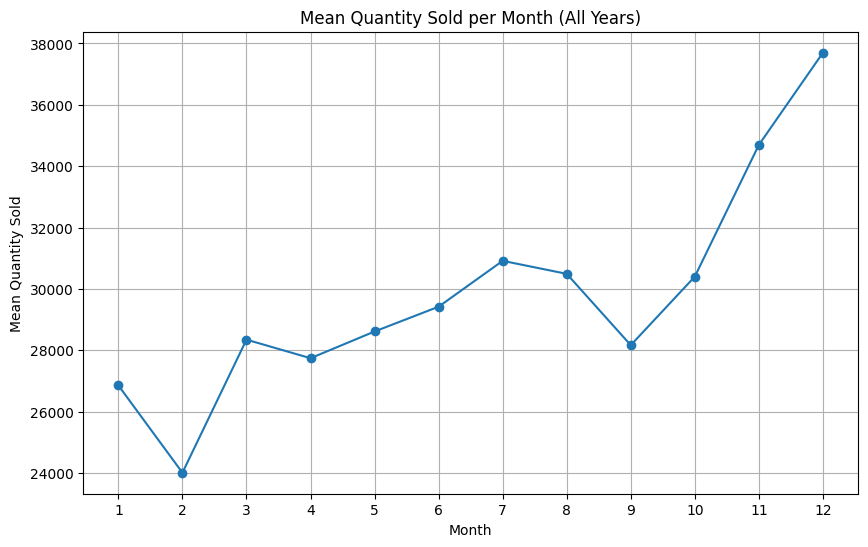

In [ ]:
# Calculate the mean quantity sold each month, regardless of the year
monthly_mean = monthly_sales.groupby('Month')['Quantity'].mean()

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(monthly_mean.index, monthly_mean.values, marker='o')
plt.xlabel('Month')
plt.ylabel('Mean Quantity Sold')
plt.title('Mean Quantity Sold per Month (All Years)')
plt.xticks(range(1, 13))  # Ensure all months are displayed on the x-axis
plt.grid(True)
plt.show()

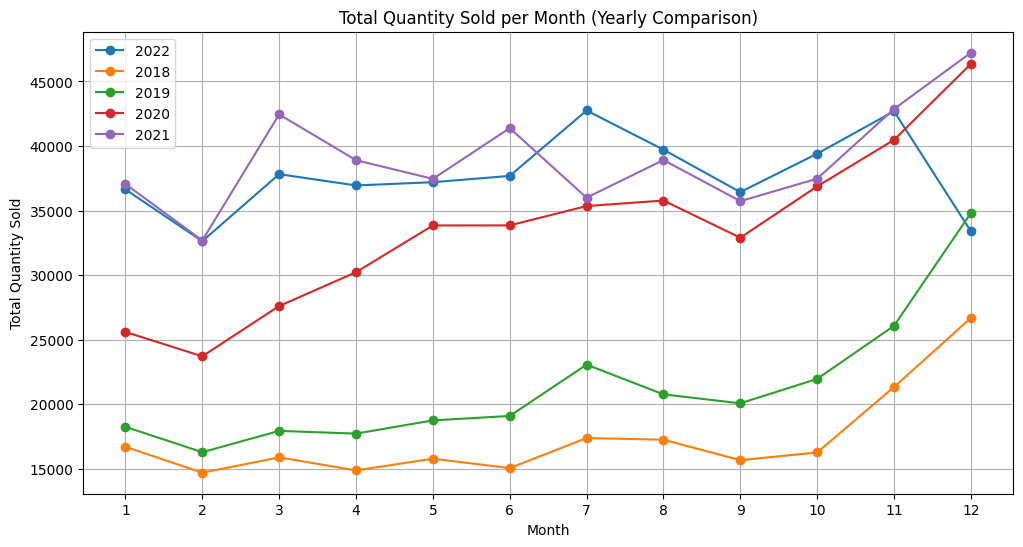

In [ ]:
# Create a plot to compare quantity sold each month across all years
plt.figure(figsize=(12, 6))
for year in df['Year'].unique():
    year_data = df[df['Year'] == year]
    monthly_data = year_data.groupby('Month')['Quantity'].sum()
    plt.plot(monthly_data.index, monthly_data.values, marker='o', label=str(year))

plt.xlabel('Month')
plt.ylabel('Total Quantity Sold')
plt.title('Total Quantity Sold per Month (Yearly Comparison)')
plt.xticks(range(1, 13))
plt.legend()
plt.grid(True)
plt.show()

## Dickey-Fuller Test

In [ ]:
#Dickey-Fuller Test (to check if the series is stationary, a requirement for ARIMA models).
from statsmodels.tsa.stattools import adfuller
result = adfuller(df.groupby('Order Date')['Quantity'].sum())
print(f"ADF Statistic: {result[0]}, p-value: {result[1]}") #IF p-value is below 0.05 the serie is stationary and dont have seasonality

ADF Statistic: -2.858273089668175, p-value: 0.05041988769223502


## Sales Evolution

### Monthly Value & Quantity

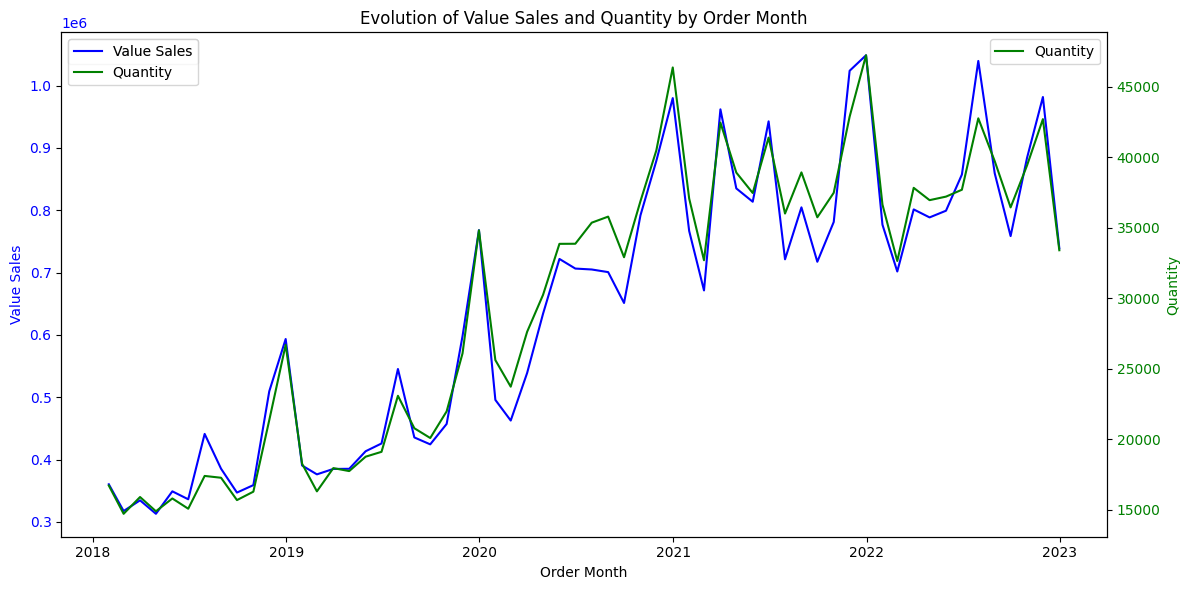

In [ ]:
# Convert 'Order Date' to datetime objects

df['Order Date'] = pd.to_datetime(df.loc[:,('Order Date')])

# Group data by month and sum the total purchase price and quantity
monthly_sales = df.groupby(pd.Grouper(key='Order Date', freq='ME'))[['Value Sales', 'Quantity']].sum()

# Create the plot with two lines (Value Sales and Quantity)
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Value Sales on the primary y-axis
sns.lineplot(x=monthly_sales.index, y=monthly_sales['Value Sales'], label='Value Sales', ax=ax1, color='blue')
ax1.set_xlabel('Order Month')
ax1.set_ylabel('Value Sales', color='blue')
ax1.tick_params('y', labelcolor='blue')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot Quantity on the secondary y-axis
sns.lineplot(x=monthly_sales.index, y=monthly_sales['Quantity'], label='Quantity', ax=ax2, color='green')
ax2.set_ylabel('Quantity', color='green')
ax2.tick_params('y', labelcolor='green')

plt.title('Evolution of Value Sales and Quantity by Order Month')
plt.xticks(rotation=45)
plt.tight_layout()
fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes) # Show legend
plt.show()

### Quarterly Value & Quantity

<ipython-input-25-6683b0c8c22d>:7: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_sales = df.groupby(pd.Grouper(key='Order Date', freq='Q'))[['Value Sales', 'Quantity']].sum()


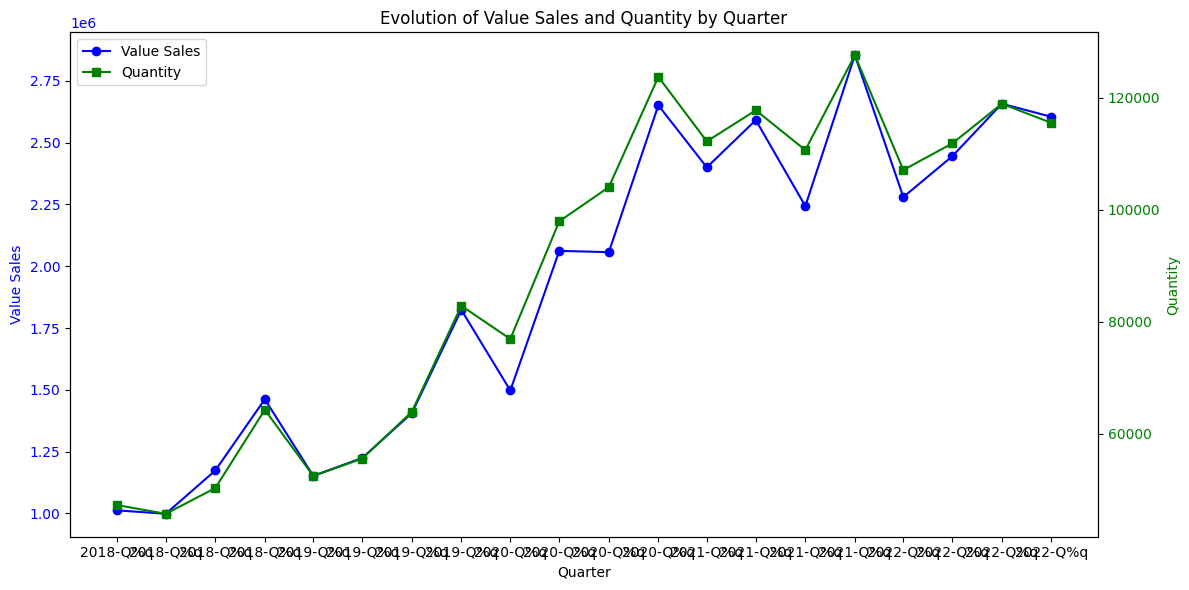

In [ ]:
#Summarised Sales by Quarter

# Ensure 'Order Date' is a datetime object
df['Order Date'] = pd.to_datetime(df.loc[:,('Order Date')])

# Group data by quarter and sum the total purchase price and quantity
quarterly_sales = df.groupby(pd.Grouper(key='Order Date', freq='Q'))[['Value Sales', 'Quantity']].sum()

# Create the plot with two lines (Value Sales and Quantity)
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create a line plot for Value Sales on the primary y-axis
ax1.plot(quarterly_sales.index, quarterly_sales['Value Sales'], label='Value Sales', color='blue', marker='o')
ax1.set_xlabel('Quarter')
ax1.set_ylabel('Value Sales', color='blue')
ax1.tick_params('y', labelcolor='blue')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Create a line plot for Quantity on the secondary y-axis
ax2.plot(quarterly_sales.index, quarterly_sales['Quantity'], label='Quantity', color='green', marker='s')
ax2.set_ylabel('Quantity', color='green')
ax2.tick_params('y', labelcolor='green')



# Formatting
plt.title('Evolution of Value Sales and Quantity by Quarter')
plt.xticks(quarterly_sales.index, [q.strftime('%Y-Q%q') for q in quarterly_sales.index])
plt.tight_layout()

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Custom legend handling
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(0,1))

plt.show()


## Review Rolling Averages

In [ ]:
# Assuming your data is called 'df'
df['Order Date'] = pd.to_datetime(df['Order Date'])  # Make sure 'Order Date' is in datetime format

# Group by Date and Category, and aggregate the data (e.g., sum of Quantity and Sales)
daily_data = df.groupby(['Order Date']).agg({
    'Quantity': 'sum',     # Summing Quantity for each category per day
    'Value Sales': 'sum'         # Summing Sales for each category per day
}).reset_index()

# Check the aggregated data
print(daily_data.head())

  Order Date  Quantity  Value Sales
0 2018-01-01     544.0     13758.87
1 2018-01-02     599.0     15264.69
2 2018-01-03     532.0     10929.09
3 2018-01-04     632.0     14426.91
4 2018-01-05     576.0     16119.67


In [ ]:
# Assuming daily_data is now the dataframe with daily aggregated data by Category
daily_data['rolling_mean_qty_7'] = daily_data['Quantity'].rolling(window=7,min_periods=1).mean().reset_index(level=0, drop=True)
daily_data['rolling_mean_sales_7'] = daily_data['Value Sales'].rolling(window=7,min_periods=1).mean().reset_index(level=0, drop=True)
daily_data['rolling_mean_qty_30'] = daily_data['Quantity'].rolling(window=30,min_periods=1).mean().reset_index(level=0, drop=True)
daily_data['rolling_mean_sales_30'] = daily_data['Value Sales'].rolling(window=30,min_periods=1).mean().reset_index(level=0, drop=True)


In [ ]:
daily_data.head(15)

,Order Date,Quantity,Value Sales,rolling_mean_qty_7,rolling_mean_sales_7,rolling_mean_qty_30,rolling_mean_sales_30
0,2018-01-01,544.0,13758.87,544.000000,13758.870000,544.000000,13758.870000
1,2018-01-02,599.0,15264.69,571.500000,14511.780000,571.500000,14511.780000
2,2018-01-03,532.0,10929.09,558.333333,13317.550000,558.333333,13317.550000
3,2018-01-04,632.0,14426.91,576.750000,13594.890000,576.750000,13594.890000
4,2018-01-05,576.0,16119.67,576.600000,14099.846000,576.600000,14099.846000
5,2018-01-06,564.0,11059.62,574.500000,13593.141667,574.500000,13593.141667
6,2018-01-07,658.0,13066.69,586.428571,13517.934286,586.428571,13517.934286
7,2018-01-08,626.0,15283.16,598.142857,13735.690000,591.375000,13738.587500
8,2018-01-09,579.0,13011.33,595.285714,13413.781429,590.000000,13657.781111
9,2018-01-10,490.0,11933.60,589.285714,13557.282857,580.000000,13485.363000


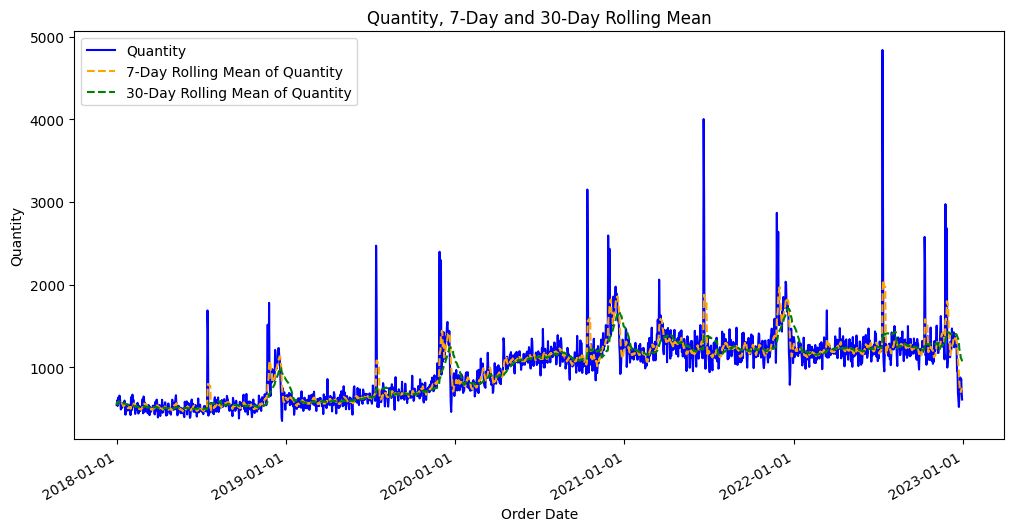

In [ ]:
import matplotlib.dates as mdates
daily_data = daily_data.set_index(pd.to_datetime(daily_data['Order Date']))

plt.figure(figsize=(12, 6))

# Plot with DatetimeIndex on the x-axis
plt.plot(daily_data.index, daily_data['Quantity'], label='Quantity', color='blue')
plt.plot(daily_data.index, daily_data['rolling_mean_qty_7'], label='7-Day Rolling Mean of Quantity', color='orange', linestyle='--')
plt.plot(daily_data.index, daily_data['rolling_mean_qty_30'], label='30-Day Rolling Mean of Quantity', color='green', linestyle='--')

plt.title('Quantity, 7-Day and 30-Day Rolling Mean')
plt.xlabel('Order Date')
plt.ylabel('Quantity')

# Format x-axis labels (optional)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.legend()
plt.show()

# Feature Engineering

### Identify Outliers

In [ ]:
#Identify outliers in sum of  Quantity per day


# Calculate the sum of Quantity per day
daily_quantity = df.groupby(['Year', 'Month', 'Day'])['Quantity'].sum().reset_index()

# Calculate IQR
Q1 = daily_quantity['Quantity'].quantile(0.25)
Q3 = daily_quantity['Quantity'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = daily_quantity[(daily_quantity['Quantity'] < lower_bound) | (daily_quantity['Quantity'] > upper_bound)]

print("Outliers in daily Quantity:")
print(outliers)


#Alternative method using the Z-score:
# Calculate the z-scores for the 'Quantity' column
daily_quantity['zscore'] = np.abs((daily_quantity['Quantity'] - daily_quantity['Quantity'].mean()) / daily_quantity['Quantity'].std())

# Identify outliers based on a z-score threshold (e.g., 3)
outliers_zscore = daily_quantity[daily_quantity['zscore'] > 3]

print("\nOutliers in daily Quantity (Z-score method):")
outliers_zscore


Outliers in daily Quantity:
      Year  Month  Day  Quantity
560   2019      7   15    2472.0
697   2019     11   29    2398.0
700   2019     12    2    2296.0
1016  2020     10   13    3151.0
1017  2020     10   14    2422.0
1061  2020     11   27    2595.0
1064  2020     11   30    2434.0
1267  2021      6   21    4004.0
1268  2021      6   22    3078.0
1425  2021     11   26    2869.0
1428  2021     11   29    2640.0
1653  2022      7   12    4840.0
1654  2022      7   13    3350.0
1744  2022     10   11    2578.0
1745  2022     10   12    2255.0
1789  2022     11   25    2974.0
1792  2022     11   28    2682.0

Outliers in daily Quantity (Z-score method):


,Year,Month,Day,Quantity,zscore
560,2019,7,15,2472.0,3.844514
697,2019,11,29,2398.0,3.654016
700,2019,12,2,2296.0,3.391437
1016,2020,10,13,3151.0,5.592464
1017,2020,10,14,2422.0,3.715799
1061,2020,11,27,2595.0,4.161153
1064,2020,11,30,2434.0,3.746691
1267,2021,6,21,4004.0,7.788342
1268,2021,6,22,3078.0,5.404540
1425,2021,11,26,2869.0,4.866511


In [ ]:
daily_quantity.head()

,Year,Month,Day,Quantity,zscore
0,2018,1,1,544.0,1.118736
1,2018,1,2,599.0,0.977150
2,2018,1,3,532.0,1.149628
3,2018,1,4,632.0,0.892198
4,2018,1,5,576.0,1.036359


### Split Data into Training, Test & Validation

In [ ]:
# split data into training, test and validation

train_data = df[df['Year'].isin([2018, 2019, 2020])]
test_data = df[df['Year'].isin([2021])]
validation_data = df[df['Year'].isin([2022])]

# Separate features (X) and target (y) for both sets
X_train = train_data[['Shipping Address','Category','Year','Month','Day']]  # Replace with your feature columns
y_train = train_data['Quantity']
X_test = test_data[['Shipping Address','Category','Year','Month','Day']]
y_test = test_data['Quantity']
X_validation_data = validation_data[['Shipping Address','Category','Year','Month','Day']]
y_validation_data = validation_data['Quantity']

In [ ]:
print(X_train.head())
print(X_test.head())
print(y_train.head())
print(y_test.head())

  Shipping Address    Category  Year  Month  Day
1               OR  3D_PRINTER  2018      3   15
2               NJ  3D_PRINTER  2018      5   25
3               OR  3D_PRINTER  2018      6    8
4               GA  3D_PRINTER  2018      6   22
5               CA  3D_PRINTER  2018      6   24
   Shipping Address    Category  Year  Month  Day
59               FL  3D_PRINTER  2021      1    3
60               AZ  3D_PRINTER  2021      2   16
61               TN  3D_PRINTER  2021      2   18
62               IN  3D_PRINTER  2021      2   24
63               GA  3D_PRINTER  2021      3   17
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
Name: Quantity, dtype: float64
59    1.0
60    1.0
61    1.0
62    1.0
63    1.0
Name: Quantity, dtype: float64


### Aggregate Data by time period

In [ ]:
daily_sales = df.groupby(['Year', 'Month', 'Day'])['Quantity'].sum().reset_index()
daily_sales['date'] = pd.to_datetime(daily_sales[['Year', 'Month', 'Day']])
daily_sales = daily_sales.set_index('date')

In [ ]:
daily_sales.head()

,Year,Month,Day,Quantity
date,,,,
2018-01-01,2018,1,1,544.0
2018-01-02,2018,1,2,599.0
2018-01-03,2018,1,3,532.0
2018-01-04,2018,1,4,632.0
2018-01-05,2018,1,5,576.0


# Model Aplication


## SARIMA, Prophet & XGBoost

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwbtofhu7/31fk6cme.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwbtofhu7/9fwyz8b6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8373', 'data', 'file=/tmp/tmpwbtofhu7/31fk6cme.json', 'init=/tmp/tmpwbtofhu7/9fwyz8b6.json', 'output', 'file=/tmp/tmpwbtofhu7/prophet_model90yy4k0b/prophet_model-20250313122553.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:25:53 - cmdstanpy - INFO - Chain

SARIMA RMSE Val: 330.55
Prophet RMSE Val: 343.85
XGBoost RMSE Val: 392.34
SARIMA RMSE: 384.42
Prophet RMSE: 732.45
XGBoost RMSE: 313.60


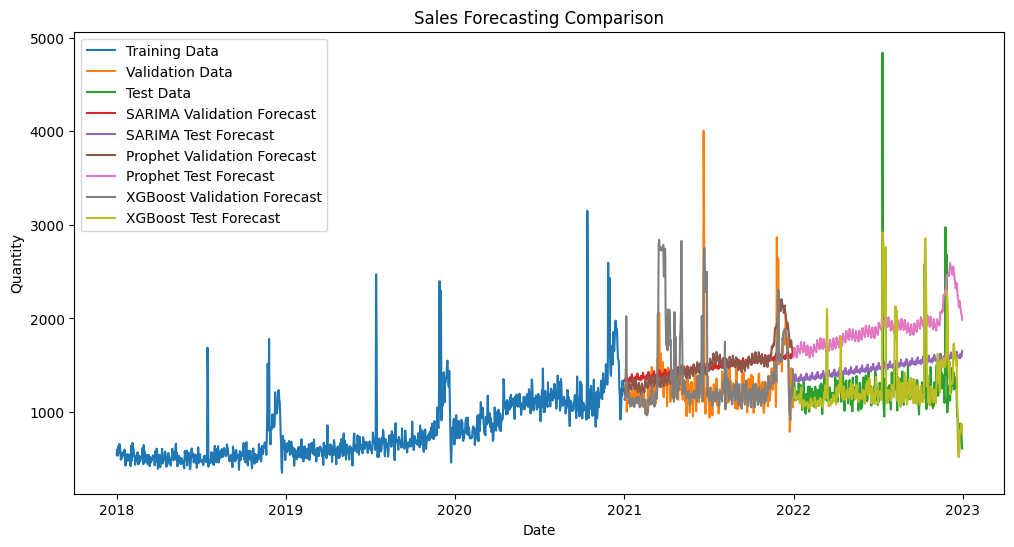

In [ ]:
# 1. Classical Time Series Approach - SARIMA
# Split data
train_ts = daily_sales[daily_sales.index.year <= 2020]
validation_ts = daily_sales[daily_sales.index.year == 2021]
test_ts = daily_sales[daily_sales.index.year == 2022]

# Fit SARIMA model (adjust parameters based on your data's seasonality)
sarima_model = SARIMAX(train_ts['Quantity'],
                      order=(1, 1, 1),  # (p,d,q) - trend components
                      seasonal_order=(1, 1, 1, 12),  # (P,D,Q,s) - seasonal components
                      enforce_stationarity=False)
sarima_results = sarima_model.fit(disp=False)

# Forecast for validation period
forecast_periods_val = len(validation_ts)
sarima_forecast_val = sarima_results.get_forecast(steps=forecast_periods_val)
sarima_pred_val = sarima_forecast_val.predicted_mean

# Forecast for test period
forecast_periods = len(test_ts)
sarima_forecast = sarima_results.get_forecast(steps=forecast_periods)
sarima_pred = sarima_forecast.predicted_mean


# 2. Prophet Approach (handles seasonality well)
prophet_data = daily_sales.reset_index()[['date', 'Quantity']]
prophet_data.columns = ['ds', 'y']  # Prophet requires these column names

# Train Prophet model
prophet_model = Prophet(yearly_seasonality=True,
                       weekly_seasonality=True,
                       daily_seasonality=False)
prophet_model.fit(prophet_data[prophet_data['ds'].dt.year <= 2020])

# Create future dataframe for predictions
future = prophet_model.make_future_dataframe(periods=len(validation_ts) + len(test_ts), freq='D')
prophet_forecast = prophet_model.predict(future)

prophet_test_pred = prophet_forecast[prophet_forecast['ds'].dt.year == 2022]['yhat'].values
prophet_test_pred_val = prophet_forecast[prophet_forecast['ds'].dt.year == 2021]['yhat'].values

# 3. ML-based Time Series Approach
def create_time_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week

    # Add lag features (previous day, week, month)
    df['lag_1'] = df['Quantity'].shift(1)
    df['lag_7'] = df['Quantity'].shift(7)
    df['lag_30'] = df['Quantity'].shift(30)

    # Add rolling means
    df['rolling_7'] = df['Quantity'].rolling(7).mean()
    df['rolling_30'] = df['Quantity'].rolling(30).mean()

    return df

# Create features and split data
ts_features = create_time_features(daily_sales)
ts_features = ts_features.dropna()  # Drop rows with NaN values from lag features

X_train_ts = ts_features[ts_features.index.year <= 2020].drop('Quantity', axis=1)
y_train_ts = ts_features[ts_features.index.year <= 2020]['Quantity']
X_validation_ts = ts_features[ts_features.index.year == 2021].drop('Quantity', axis=1)
y_validation_ts = ts_features[ts_features.index.year == 2021]['Quantity']
X_test_ts = ts_features[ts_features.index.year == 2022].drop('Quantity', axis=1)
y_test_ts = ts_features[ts_features.index.year == 2022]['Quantity']

# Use XGBoost for time series
from xgboost import XGBRegressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train_ts, y_train_ts)
xgb_pred_val = xgb_model.predict(X_validation_ts)
xgb_pred = xgb_model.predict(X_test_ts)

# Evaluate models
sarima_rmse_val = np.sqrt(mean_squared_error(validation_ts['Quantity'], sarima_pred_val))
sarima_rmse = np.sqrt(mean_squared_error(test_ts['Quantity'], sarima_pred))
prophet_rmse_val = np.sqrt(mean_squared_error(validation_ts['Quantity'], prophet_test_pred_val))
prophet_rmse = np.sqrt(mean_squared_error(test_ts['Quantity'], prophet_test_pred))
xgb_rmse_val = np.sqrt(mean_squared_error(y_validation_ts, xgb_pred_val))
xgb_rmse = np.sqrt(mean_squared_error(y_test_ts, xgb_pred))

print(f"SARIMA RMSE Val: {sarima_rmse_val:.2f}")
print(f"Prophet RMSE Val: {prophet_rmse_val:.2f}")
print(f"XGBoost RMSE Val: {xgb_rmse_val:.2f}")

print(f"SARIMA RMSE: {sarima_rmse:.2f}")
print(f"Prophet RMSE: {prophet_rmse:.2f}")
print(f"XGBoost RMSE: {xgb_rmse:.2f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train_ts.index, train_ts['Quantity'], label='Training Data')
plt.plot(validation_ts.index, validation_ts['Quantity'], label='Validation Data')
plt.plot(test_ts.index, test_ts['Quantity'], label='Test Data')

plt.plot(validation_ts.index, sarima_pred_val, label='SARIMA Validation Forecast')
plt.plot(test_ts.index, sarima_pred, label='SARIMA Test Forecast')
plt.plot(validation_ts.index, prophet_test_pred_val, label='Prophet Validation Forecast')
plt.plot(test_ts.index, prophet_test_pred, label='Prophet Test Forecast')
plt.plot(validation_ts.index, xgb_pred_val, label='XGBoost Validation Forecast')
plt.plot(test_ts.index, xgb_pred, label='XGBoost Test Forecast')

plt.legend()
plt.title('Sales Forecasting Comparison')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.show()


In [ ]:
# prompt: Can you calculate the performance metrics for the training data including RMSE and MAPE?

def calculate_mape(actual, predicted):
    """Calculates the Mean Absolute Percentage Error (MAPE)."""
    # Avoid division by zero
    actual = np.array(actual)  # convert to numpy for vectorized operations
    predicted = np.array(predicted)
    mask = actual != 0
    return np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100

# Assuming you have your predictions and actual values in the variables:
# y_train (actual values)
# sarima_pred_val, prophet_test_pred_val, xgb_pred_val (validation predictions)
# sarima_pred, prophet_test_pred, xgb_pred (test predictions)

# Calculate MAPE for Validation Sets
sarima_mape_val = calculate_mape(validation_ts['Quantity'], sarima_pred_val)
prophet_mape_val = calculate_mape(validation_ts['Quantity'], prophet_test_pred_val)
xgb_mape_val = calculate_mape(y_validation_ts, xgb_pred_val)

# Calculate MAPE for Test Sets
sarima_mape = calculate_mape(test_ts['Quantity'], sarima_pred)
prophet_mape = calculate_mape(test_ts['Quantity'], prophet_test_pred)
xgb_mape = calculate_mape(y_test_ts, xgb_pred)

print(f"SARIMA MAPE Val: {sarima_mape_val:.2f}%")
print(f"Prophet MAPE Val: {prophet_mape_val:.2f}%")
print(f"XGBoost MAPE Val: {xgb_mape_val:.2f}%")

print(f"SARIMA MAPE: {sarima_mape:.2f}%")
print(f"Prophet MAPE: {prophet_mape:.2f}%")
print(f"XGBoost MAPE: {xgb_mape:.2f}%")


SARIMA MAPE Val: 20.86%
Prophet MAPE Val: 21.48%
XGBoost MAPE Val: 16.22%
SARIMA MAPE: 24.63%
Prophet MAPE: 58.28%
XGBoost MAPE: 12.96%


## Mean Absolute Percentage Error (MAPE)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
# Calculate MAPE for SARIMA
sarima_mape= mean_absolute_percentage_error(test_ts['Quantity'], sarima_pred)

# Calculate MAPE for Prophet

prophet_mape= mean_absolute_percentage_error(test_ts['Quantity'], prophet_test_pred)

# Calculate MAPE for XGBoost
xgb_mape= mean_absolute_percentage_error(y_test_ts, xgb_pred)

# Print RMSE and MAPE results
print(f"SARIMA RMSE: {sarima_rmse:.2f}, MAPE: {sarima_mape:.2f}%")
print(f"Prophet RMSE: {prophet_rmse:.2f}, MAPE: {prophet_mape:.2f}%")
print(f"XGBoost RMSE: {xgb_rmse:.2f}, MAPE: {xgb_mape:.2f}%")

SARIMA RMSE: 384.42, MAPE: 24.63%
Prophet RMSE: 732.45, MAPE: 58.28%
XGBoost RMSE: 313.60, MAPE: 12.96%


## SARIMA, Prophet & XGBoost: Smoothed


In [ ]:
#Re define Daily sales
daily_sales = df.groupby(['Year', 'Month', 'Day'])['Quantity'].sum().reset_index()
daily_sales['date'] = pd.to_datetime(daily_sales[['Year', 'Month', 'Day']])
daily_sales = daily_sales.set_index('date')

In [ ]:
daily_sales.head()

,Year,Month,Day,Quantity
date,,,,
2018-01-01,2018,1,1,544.0
2018-01-02,2018,1,2,599.0
2018-01-03,2018,1,3,532.0
2018-01-04,2018,1,4,632.0
2018-01-05,2018,1,5,576.0


In [ ]:
daily_sales['rolling_7'] = daily_sales['Quantity'].rolling(window=7, min_periods=1).mean()

daily_sales.head()

,Year,Month,Day,Quantity,rolling_7
date,,,,,
2018-01-01,2018,1,1,544.0,544.000000
2018-01-02,2018,1,2,599.0,571.500000
2018-01-03,2018,1,3,532.0,558.333333
2018-01-04,2018,1,4,632.0,576.750000
2018-01-05,2018,1,5,576.0,576.600000


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
DEBUG:cmdstanpy:input tempfile: /tmp/tmp800wvlqr/0p31dbrl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp800wvlqr/ojvlo_36.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94712', 'data', 'file=/tmp/tmp800wvlqr/0p31dbrl.json', 'init=/tmp/tmp800wvlqr/ojvlo_36.json', 'output', 'file=/tmp/tmp800wvlqr/prophet_model64f5hay1/prophet_model-20250312231701.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:17:01 - cmdstanpy - INFO - Chai

SARIMA RMSE Val: 180.58
Prophet RMSE Val: 196.32
XGBoost RMSE Val: 56.63
SARIMA RMSE: 194.67
Prophet RMSE: 475.54
XGBoost RMSE: 66.43


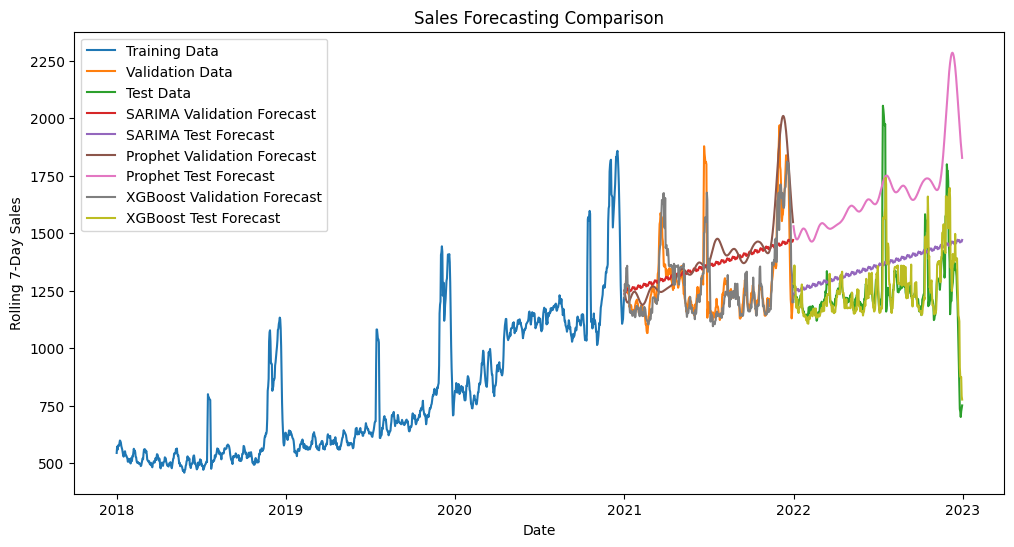

In [ ]:
# 1. Classical Time Series Approach - SARIMA
# Split data
train_ts = daily_sales[daily_sales.index.year <= 2020]
validation_ts = daily_sales[daily_sales.index.year == 2021]
test_ts = daily_sales[daily_sales.index.year == 2022]

# Fit SARIMA model (adjust parameters based on your data's seasonality)
sarima_model = SARIMAX(train_ts['rolling_7'],
                      order=(1, 1, 1),  # (p,d,q) - trend components
                      seasonal_order=(1, 1, 1, 12),  # (P,D,Q,s) - seasonal components
                      enforce_stationarity=False)
sarima_results = sarima_model.fit(disp=False)

# Forecast for validation period
forecast_periods_val = len(validation_ts)
sarima_forecast_val = sarima_results.get_forecast(steps=forecast_periods_val)
sarima_pred_val = sarima_forecast_val.predicted_mean

# Forecast for test period
forecast_periods = len(test_ts)
sarima_forecast = sarima_results.get_forecast(steps=forecast_periods)
sarima_pred = sarima_forecast.predicted_mean


# 2. Prophet Approach (handles seasonality well)
prophet_data = daily_sales.reset_index()[['date', 'rolling_7']]
prophet_data.columns = ['ds', 'y']  # Prophet requires these column names

# Train Prophet model
prophet_model = Prophet(yearly_seasonality=True,
                       weekly_seasonality=True,
                       daily_seasonality=False)
prophet_model.fit(prophet_data[prophet_data['ds'].dt.year <= 2020])

# Create future dataframe for predictions
future = prophet_model.make_future_dataframe(periods=len(validation_ts) + len(test_ts), freq='D')
prophet_forecast = prophet_model.predict(future)

prophet_test_pred = prophet_forecast[prophet_forecast['ds'].dt.year == 2022]['yhat'].values
prophet_test_pred_val = prophet_forecast[prophet_forecast['ds'].dt.year == 2021]['yhat'].values

# 3. ML-based Time Series Approach
def create_time_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week

    # Add lag features (previous day, week, month)
    df['lag_1'] = df['rolling_7'].shift(1)
    df['lag_7'] = df['rolling_7'].shift(7)
    df['lag_30'] = df['rolling_7'].shift(30)

    # Add rolling means
    df['rolling_7'] = df['rolling_7'].rolling(7).mean()
    df['rolling_30'] = df['rolling_7'].rolling(30).mean()

    return df

# Create features and split data
ts_features = create_time_features(daily_sales)
ts_features = ts_features.dropna()  # Drop rows with NaN values from lag features

X_train_ts = ts_features[ts_features.index.year <= 2020].drop('rolling_7', axis=1)
y_train_ts = ts_features[ts_features.index.year <= 2020]['rolling_7']
X_validation_ts = ts_features[ts_features.index.year == 2021].drop('rolling_7', axis=1)
y_validation_ts = ts_features[ts_features.index.year == 2021]['rolling_7']
X_test_ts = ts_features[ts_features.index.year == 2022].drop('rolling_7', axis=1)
y_test_ts = ts_features[ts_features.index.year == 2022]['rolling_7']

# Use XGBoost for time series
from xgboost import XGBRegressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train_ts, y_train_ts)
xgb_pred_val = xgb_model.predict(X_validation_ts)
xgb_pred = xgb_model.predict(X_test_ts)


# Evaluate models
sarima_rmse_val = np.sqrt(mean_squared_error(validation_ts['rolling_7'], sarima_pred_val))
sarima_rmse = np.sqrt(mean_squared_error(test_ts['rolling_7'], sarima_pred))
prophet_rmse_val = np.sqrt(mean_squared_error(validation_ts['rolling_7'], prophet_test_pred_val))
prophet_rmse = np.sqrt(mean_squared_error(test_ts['rolling_7'], prophet_test_pred))
xgb_rmse_val = np.sqrt(mean_squared_error(y_validation_ts, xgb_pred_val))
xgb_rmse = np.sqrt(mean_squared_error(y_test_ts, xgb_pred))

print(f"SARIMA RMSE Val: {sarima_rmse_val:.2f}")
print(f"Prophet RMSE Val: {prophet_rmse_val:.2f}")
print(f"XGBoost RMSE Val: {xgb_rmse_val:.2f}")

print(f"SARIMA RMSE: {sarima_rmse:.2f}")
print(f"Prophet RMSE: {prophet_rmse:.2f}")
print(f"XGBoost RMSE: {xgb_rmse:.2f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train_ts.index, train_ts['rolling_7'], label='Training Data')
plt.plot(validation_ts.index, validation_ts['rolling_7'], label='Validation Data')
plt.plot(test_ts.index, test_ts['rolling_7'], label='Test Data')

plt.plot(validation_ts.index, sarima_pred_val, label='SARIMA Validation Forecast')
plt.plot(test_ts.index, sarima_pred, label='SARIMA Test Forecast')
plt.plot(validation_ts.index, prophet_test_pred_val, label='Prophet Validation Forecast')
plt.plot(test_ts.index, prophet_test_pred, label='Prophet Test Forecast')
plt.plot(validation_ts.index, xgb_pred_val, label='XGBoost Validation Forecast')
plt.plot(test_ts.index, xgb_pred, label='XGBoost Test Forecast')

plt.legend()
plt.title('Sales Forecasting Comparison')
plt.xlabel('Date')
plt.ylabel('Rolling 7-Day Sales')
plt.show()

# Neural Networks

In [ ]:
# redefine dailes sales to perform NN model evaluation
daily_sales = df.groupby(['Year', 'Month', 'Day'])['Quantity'].sum().reset_index()
daily_sales['date'] = pd.to_datetime(daily_sales[['Year', 'Month', 'Day']])
daily_sales = daily_sales.set_index('date')
daily_sales.head()

,Year,Month,Day,Quantity
date,,,,
2018-01-01,2018,1,1,680.0
2018-01-02,2018,1,2,708.0
2018-01-03,2018,1,3,645.0
2018-01-04,2018,1,4,745.0
2018-01-05,2018,1,5,669.0


### LSTM

LSTM Validation (2021) Forecast RMSE: 413.14
LSTM Test (2022) Forecast RMSE: 384.48


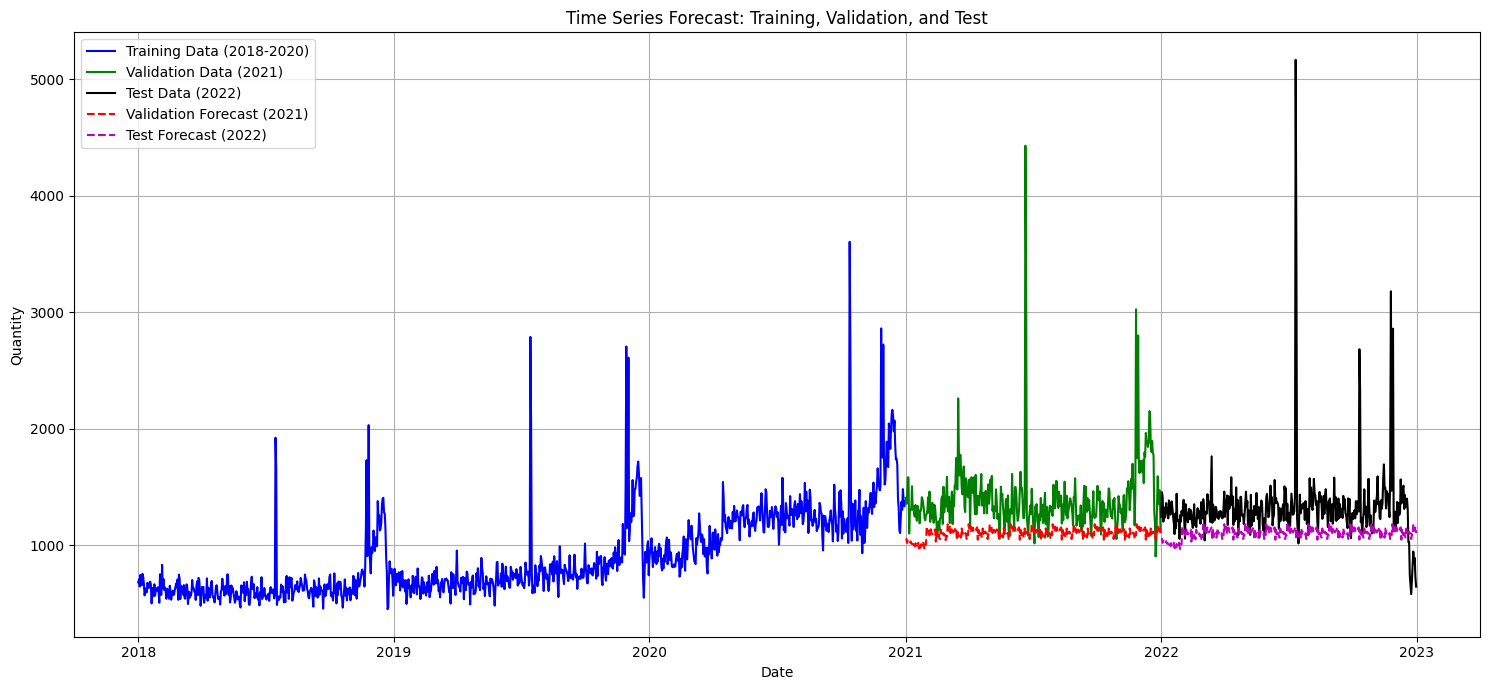

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Prepare time series data function
def prepare_time_series_data(series, n_lag=365, n_seq=365):
    scaler = MinMaxScaler(feature_range=(0, 1))
    series_scaled = scaler.fit_transform(series.values.reshape(-1, 1))

    X, y = [], []
    for i in range(len(series_scaled) - n_lag - n_seq + 1):
        X.append(series_scaled[i:(i + n_lag), 0])
        y.append(series_scaled[(i + n_lag):(i + n_lag + n_seq), 0])

    return np.array(X), np.array(y), scaler

# Split data
train_data = daily_sales[daily_sales.index.year <= 2020]['Quantity']
validation_data = daily_sales[daily_sales.index.year == 2021]['Quantity']
test_data = daily_sales[daily_sales.index.year == 2022]['Quantity']

# Parameters
lag_days = 90  # Input window size
forecast_days = 30  # Prediction window size

# Prepare data for training
X_train, y_train, scaler_train = prepare_time_series_data(train_data, lag_days, forecast_days)

# Reshape data for LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Build the model
input_layer = Input(shape=(lag_days, 1))

# First Bidirectional LSTM layer
x = Bidirectional(LSTM(64, activation='relu', return_sequences=True))(input_layer)
x = Dropout(0.4)(x)

# Second LSTM layer
x = LSTM(50, activation='relu', return_sequences=True)(x)
x = Dropout(0.3)(x)

# Third LSTM layer
x = LSTM(25, activation='relu', return_sequences=False)(x)
x = Dropout(0.3)(x)

# Output layer
output_layer = Dense(forecast_days)(x)

lstm_model = Model(inputs=input_layer, outputs=output_layer)

# Set optimizer with custom learning rate
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compile model
lstm_model.compile(optimizer=optimizer, loss='mse')

# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train Model
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=0
)

# Forecasting function
def generate_full_year_forecast(model, history_data, forecast_dates, scaler, lag_days, forecast_days):
    history = history_data.copy().values
    predictions = pd.DataFrame(index=forecast_dates, columns=['Forecast'])

    for i in range(0, len(forecast_dates), forecast_days):
        input_seq = history[-lag_days:].reshape(-1, 1)
        input_seq_scaled = scaler.transform(input_seq)
        input_seq_scaled = input_seq_scaled.reshape(1, lag_days, 1)
        forecast_scaled = model.predict(input_seq_scaled, verbose=0)
        forecast = scaler.inverse_transform(forecast_scaled)[0]

        days_to_forecast = min(forecast_days, len(forecast_dates) - i)
        for j in range(days_to_forecast):
            if i + j < len(forecast_dates):
                predictions.loc[forecast_dates[i + j], 'Forecast'] = forecast[j]

        history = np.append(history, forecast[:days_to_forecast])

    return predictions

# First validate on 2021 data (validation set)
validation_dates = pd.date_range(start='2021-01-01', end='2021-12-31', freq='D')
validation_forecast = generate_full_year_forecast(
    lstm_model, train_data, validation_dates, scaler_train, lag_days, forecast_days
)

# Evaluate on validation data (2021)
validation_aligned = validation_data.reindex(validation_dates)
validation_rmse = np.sqrt(mean_squared_error(validation_aligned.dropna(),
                                        validation_forecast.loc[validation_aligned.dropna().index]))
print(f"LSTM Validation (2021) Forecast RMSE: {validation_rmse:.2f}")

# Then test on 2022 data (test set)
# First, update the model with 2021 data for forecasting 2022
updated_train_data = pd.concat([train_data, validation_data])
test_dates = pd.date_range(start='2022-01-01', end='2022-12-31', freq='D')
test_forecast = generate_full_year_forecast(
    lstm_model, updated_train_data, test_dates, scaler_train, lag_days, forecast_days
)

# Evaluate on test data (2022)
test_aligned = test_data.reindex(test_dates)
test_rmse = np.sqrt(mean_squared_error(test_aligned.dropna(),
                                  test_forecast.loc[test_aligned.dropna().index]))
print(f"LSTM Test (2022) Forecast RMSE: {test_rmse:.2f}")

# Plot Predictions
plt.figure(figsize=(15, 7))
plt.plot(train_data.index, train_data.values, 'b-', label='Training Data (2018-2020)')
plt.plot(validation_data.index, validation_data.values, 'g-', label='Validation Data (2021)')
plt.plot(test_data.index, test_data.values, 'k-', label='Test Data (2022)')
plt.plot(validation_forecast.index, validation_forecast['Forecast'], 'r--', label='Validation Forecast (2021)')
plt.plot(test_forecast.index, test_forecast['Forecast'], 'm--', label='Test Forecast (2022)')

plt.title('Time Series Forecast: Training, Validation, and Test')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### MAPE

In [ ]:
# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Calculate MAPE for validation data (2021)
validation_actual = validation_aligned.dropna().values
validation_predicted = validation_forecast.loc[validation_aligned.dropna().index, 'Forecast'].values
validation_mape = mean_absolute_percentage_error(validation_actual, validation_predicted)
print(f'Validation (2021) MAPE: {validation_mape:.2f}%')

# Calculate MAPE for test data (2022)
test_actual = test_aligned.dropna().values
test_predicted = test_forecast.loc[test_aligned.dropna().index, 'Forecast'].values
test_mape = mean_absolute_percentage_error(test_actual, test_predicted)
print(f'Test (2022) MAPE: {test_mape:.2f}%')

Validation (2021) MAPE: 19.30%
Test (2022) MAPE: 16.93%


#### Smoothed

In [ ]:
daily_sales.head()

,Year,Month,Day,Quantity
date,,,,
2018-01-01,2018,1,1,680.0
2018-01-02,2018,1,2,708.0
2018-01-03,2018,1,3,645.0
2018-01-04,2018,1,4,745.0
2018-01-05,2018,1,5,669.0


In [ ]:
daily_sales['rolling_7'] = daily_sales['Quantity'].rolling(window=7, min_periods=1).mean()
daily_sales = daily_sales.drop(columns=['Quantity'])
daily_sales.head()

,Year,Month,Day,rolling_7
date,,,,
2018-01-01,2018,1,1,544.000000
2018-01-02,2018,1,2,571.500000
2018-01-03,2018,1,3,558.333333
2018-01-04,2018,1,4,576.750000
2018-01-05,2018,1,5,576.600000


LSTM Validation (2021) RMSE: 420.85
LSTM Validation (2021) MAPE: 28.92%
LSTM Test (2022) RMSE: 381.50
LSTM Test (2022) MAPE: 27.64%


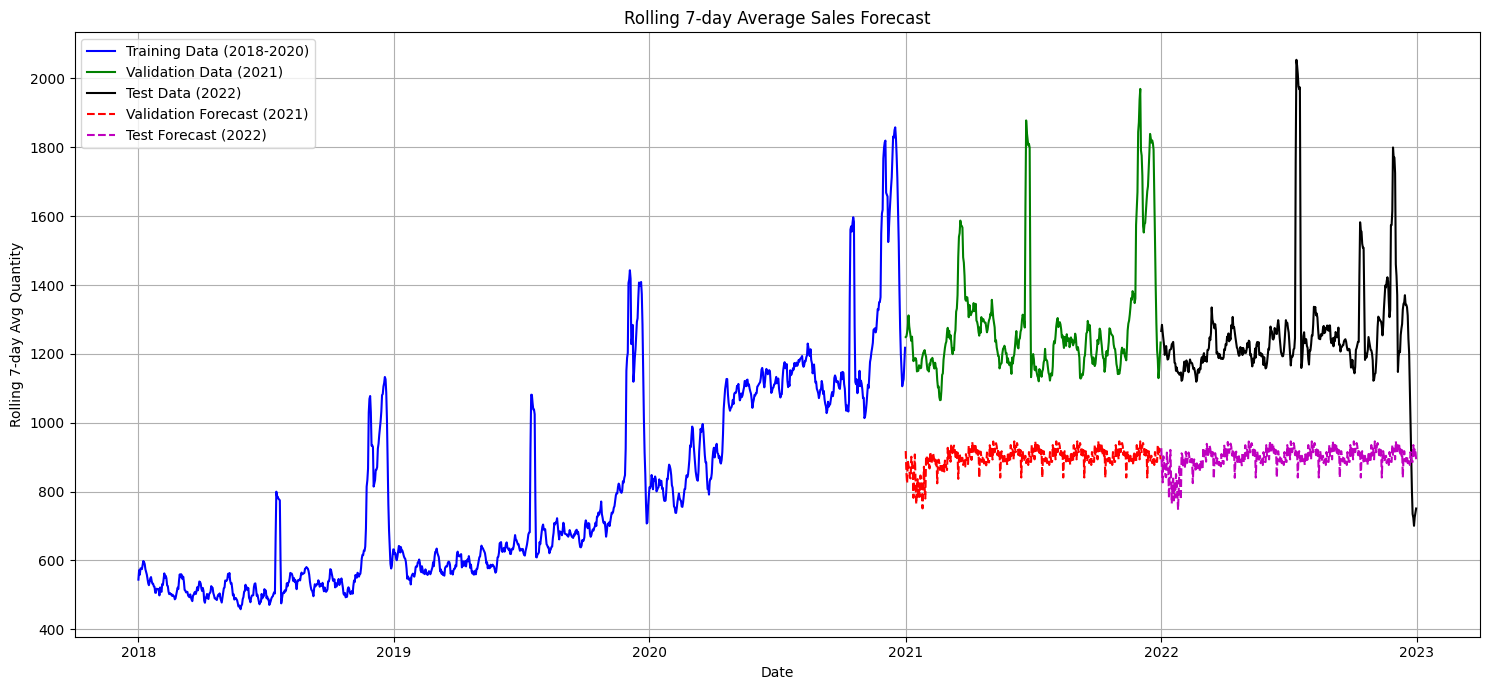

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Split dataset - ensuring validation is 2021 and test is 2022
train_data = daily_sales[daily_sales.index.year <= 2020]['rolling_7']
validation_data = daily_sales[daily_sales.index.year == 2021]['rolling_7']
test_data = daily_sales[daily_sales.index.year == 2022]['rolling_7']

# Prepare time series data
def prepare_time_series_data(series, n_lag=90, n_seq=30):
    scaler = MinMaxScaler(feature_range=(0, 1))
    series_scaled = scaler.fit_transform(series.values.reshape(-1, 1))

    X, y = [], []
    for i in range(len(series_scaled) - n_lag - n_seq + 1):
        X.append(series_scaled[i:(i + n_lag), 0])
        y.append(series_scaled[(i + n_lag):(i + n_lag + n_seq), 0])

    return np.array(X), np.array(y), scaler

# Define parameters
lag_days = 90   # Input window size
forecast_days = 30  # Prediction window size

# Prepare data for training
X_train, y_train, scaler_train = prepare_time_series_data(train_data, lag_days, forecast_days)

# Reshape data for LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Define LSTM model
input_layer = Input(shape=(lag_days, 1))
x = Bidirectional(LSTM(64, activation='relu', return_sequences=True))(input_layer)
x = Dropout(0.4)(x)
x = LSTM(50, activation='relu', return_sequences=True)(x)
x = Dropout(0.3)(x)
x = LSTM(25, activation='relu', return_sequences=False)(x)
x = Dropout(0.3)(x)
output_layer = Dense(forecast_days)(x)

lstm_model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
optimizer = Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimizer, loss='mse')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
lstm_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=0
)

# Forecast function
def generate_full_year_forecast(model, history_data, forecast_dates, scaler, lag_days, forecast_days):
    history = history_data.copy().values
    predictions = pd.DataFrame(index=forecast_dates, columns=['Forecast'])

    for i in range(0, len(forecast_dates), forecast_days):
        input_seq = history[-lag_days:].reshape(-1, 1)
        input_seq_scaled = scaler.transform(input_seq)
        input_seq_scaled = input_seq_scaled.reshape(1, lag_days, 1)
        forecast_scaled = model.predict(input_seq_scaled, verbose=0)
        forecast = scaler.inverse_transform(forecast_scaled)[0]

        days_to_forecast = min(forecast_days, len(forecast_dates) - i)
        for j in range(days_to_forecast):
            if i + j < len(forecast_dates):
                predictions.loc[forecast_dates[i + j], 'Forecast'] = forecast[j]

        history = np.append(history, forecast[:days_to_forecast])

    return predictions

# First generate 2021 forecast (validation period)
validation_dates = pd.date_range(start='2021-01-01', end='2021-12-31', freq='D')
validation_forecast = generate_full_year_forecast(
    lstm_model, train_data, validation_dates, scaler_train, lag_days, forecast_days
)

# Evaluate model on validation data
validation_aligned = validation_data.reindex(validation_dates)
validation_rmse = np.sqrt(mean_squared_error(
    validation_aligned.dropna(),
    validation_forecast.loc[validation_aligned.dropna().index]
))
validation_mape = mean_absolute_percentage_error(
    validation_aligned.dropna().values,
    validation_forecast.loc[validation_aligned.dropna().index].values
)
print(f"LSTM Validation (2021) RMSE: {validation_rmse:.2f}")
print(f"LSTM Validation (2021) MAPE: {validation_mape:.2f}%")

# Then generate 2022 forecast (test period)
# First update history with validation data
test_dates = pd.date_range(start='2022-01-01', end='2022-12-31', freq='D')
updated_history = pd.concat([train_data, validation_data])
test_forecast = generate_full_year_forecast(
    lstm_model, updated_history, test_dates, scaler_train, lag_days, forecast_days
)

# Evaluate model on test data
test_aligned = test_data.reindex(test_dates)
test_rmse = np.sqrt(mean_squared_error(
    test_aligned.dropna(),
    test_forecast.loc[test_aligned.dropna().index]
))
test_mape = mean_absolute_percentage_error(
    test_aligned.dropna().values,
    test_forecast.loc[test_aligned.dropna().index].values
)
print(f"LSTM Test (2022) RMSE: {test_rmse:.2f}")
print(f"LSTM Test (2022) MAPE: {test_mape:.2f}%")

# Plot results
plt.figure(figsize=(15, 7))
plt.plot(train_data.index, train_data.values, 'b-', label='Training Data (2018-2020)')
plt.plot(validation_data.index, validation_data.values, 'g-', label='Validation Data (2021)')
plt.plot(test_data.index, test_data.values, 'k-', label='Test Data (2022)')
plt.plot(validation_forecast.index, validation_forecast['Forecast'], 'r--', label='Validation Forecast (2021)')
plt.plot(test_forecast.index, test_forecast['Forecast'], 'm--', label='Test Forecast (2022)')
plt.title('Rolling 7-day Average Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Rolling 7-day Avg Quantity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Grid Search

In [ ]:
pip install keras-tuner

In [ ]:
# Redefine dailes sales to perform Grid Search
daily_sales = df.groupby(['Year', 'Month', 'Day'])['Quantity'].sum().reset_index()
daily_sales['date'] = pd.to_datetime(daily_sales[['Year', 'Month', 'Day']])
daily_sales = daily_sales.set_index('date')
daily_sales.head()

,Year,Month,Day,Quantity
date,,,,
2018-01-01,2018,1,1,544.0
2018-01-02,2018,1,2,599.0
2018-01-03,2018,1,3,532.0
2018-01-04,2018,1,4,632.0
2018-01-05,2018,1,5,576.0


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best hyperparameters found:
First LSTM units: 128
Second LSTM units: 128
Third LSTM units: 64
Dropout rates: 0.30000000000000004, 0.30000000000000004, 0.30000000000000004
Learning rate: 0.0005
Optimizer: adam


## Tunned LSTM

Validation (2021) RMSE: 278.78
Validation (2021) MAPE: 10.84%
Test (2022) RMSE: 305.11
Test (2022) MAPE: 11.02%


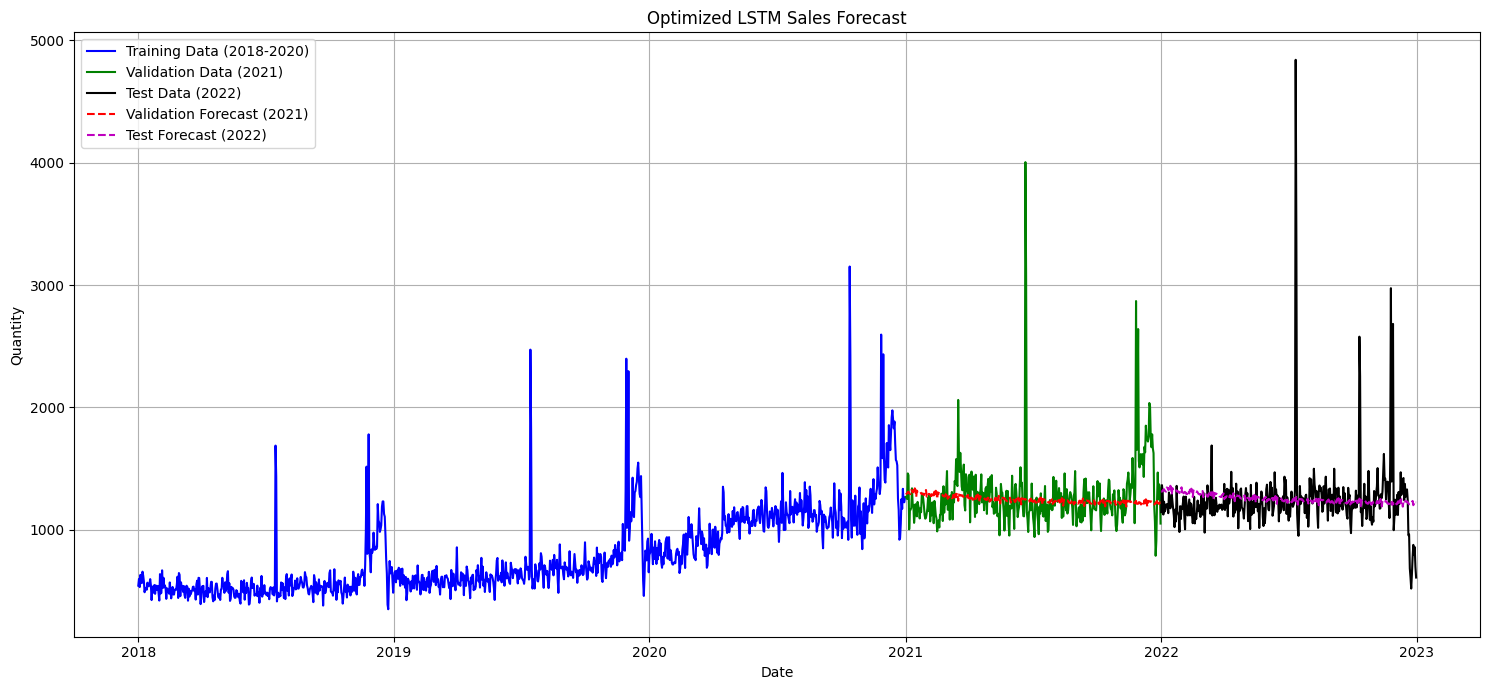

In [ ]:
# Build the best model with the optimal hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model with early stopping
history = best_model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=0
)

# Forecasting function
def generate_full_year_forecast(model, history_data, forecast_dates, scaler, lag_days, forecast_days):
    history = history_data.copy().values
    predictions = pd.DataFrame(index=forecast_dates, columns=['Forecast'])

    for i in range(0, len(forecast_dates), forecast_days):
        input_seq = history[-lag_days:].reshape(-1, 1)
        input_seq_scaled = scaler.transform(input_seq)
        input_seq_scaled = input_seq_scaled.reshape(1, lag_days, 1)
        forecast_scaled = model.predict(input_seq_scaled, verbose=0)
        forecast = scaler.inverse_transform(forecast_scaled)[0]

        days_to_forecast = min(forecast_days, len(forecast_dates) - i)
        for j in range(days_to_forecast):
            if i + j < len(forecast_dates):
                predictions.loc[forecast_dates[i + j], 'Forecast'] = forecast[j]

        history = np.append(history, forecast[:days_to_forecast])

    return predictions

# Evaluate on validation data (2021)
validation_dates = pd.date_range(start='2021-01-01', end='2021-12-31', freq='D')
validation_forecast = generate_full_year_forecast(
    best_model, train_data, validation_dates, scaler_train, lag_days, forecast_days
)

validation_aligned = validation_data.reindex(validation_dates)
validation_rmse = np.sqrt(mean_squared_error(
    validation_aligned.dropna(),
    validation_forecast.loc[validation_aligned.dropna().index]
))
validation_mape = mean_absolute_percentage_error(
    validation_aligned.dropna().values,
    validation_forecast.loc[validation_aligned.dropna().index].values
)
print(f"Validation (2021) RMSE: {validation_rmse:.2f}")
print(f"Validation (2021) MAPE: {validation_mape:.2f}%")

# Now evaluate on test data (2022)
# Update history with validation data
test_dates = pd.date_range(start='2022-01-01', end='2022-12-31', freq='D')
updated_history = pd.concat([train_data, validation_data])
test_forecast = generate_full_year_forecast(
    best_model, updated_history, test_dates, scaler_train, lag_days, forecast_days
)

test_aligned = test_data.reindex(test_dates)
test_rmse = np.sqrt(mean_squared_error(
    test_aligned.dropna(),
    test_forecast.loc[test_aligned.dropna().index]
))
test_mape = mean_absolute_percentage_error(
    test_aligned.dropna().values,
    test_forecast.loc[test_aligned.dropna().index].values
)
print(f"Test (2022) RMSE: {test_rmse:.2f}")
print(f"Test (2022) MAPE: {test_mape:.2f}%")

# Plot results
plt.figure(figsize=(15, 7))
plt.plot(train_data.index, train_data.values, 'b-', label='Training Data (2018-2020)')
plt.plot(validation_data.index, validation_data.values, 'g-', label='Validation Data (2021)')
plt.plot(test_data.index, test_data.values, 'k-', label='Test Data (2022)')
plt.plot(validation_forecast.index, validation_forecast['Forecast'], 'r--', label='Validation Forecast (2021)')
plt.plot(test_forecast.index, test_forecast['Forecast'], 'm--', label='Test Forecast (2022)')
plt.title('Optimized LSTM Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Cross Validation

In [ ]:
# Redefine dailes sales to perform Grid Search
daily_sales = df.groupby(['Year', 'Month', 'Day'])['Quantity'].sum().reset_index()
daily_sales['date'] = pd.to_datetime(daily_sales[['Year', 'Month', 'Day']])
daily_sales = daily_sales.set_index('date')
daily_sales.head()

,Year,Month,Day,Quantity
date,,,,
2018-01-01,2018,1,1,544.0
2018-01-02,2018,1,2,599.0
2018-01-03,2018,1,3,532.0
2018-01-04,2018,1,4,632.0
2018-01-05,2018,1,5,576.0


## Cross Validation All Models

Training XGBoost model...
XGBoost Validation - RMSE: 465.99, MAPE: 20.34%, R²: -1.9402
XGBoost Test - RMSE: 366.47, MAPE: 15.48%, R²: -0.4863
Training SARIMA model...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


SARIMA Validation - RMSE: 328.72, MAPE: 20.66%, R²: -0.4631
SARIMA Test - RMSE: 579.16, MAPE: 45.71%, R²: -2.7121
Training Prophet model...


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx4ng2upx/numxn8_3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx4ng2upx/i338rirs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62784', 'data', 'file=/tmp/tmpx4ng2upx/numxn8_3.json', 'init=/tmp/tmpx4ng2upx/i338rirs.json', 'output', 'file=/tmp/tmpx4ng2upx/prophet_model8fwpgy73/prophet_model-20250313090227.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:02:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:02:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet Validation - RMSE: 343.85, MAPE: 21.48%, R²: -0.6009
Prophet Test - RMSE: 732.45, MAPE: 58.28%, R²: -4.9372
Training LSTM model...
Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 292ms/step - loss: 0.0207 - val_loss: 0.0496
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0107 - val_loss: 0.0267
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0078 - val_loss: 0.0183
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0069 - val_loss: 0.0162
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0061 - val_loss: 0.0155
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0060 - val_loss: 0.0160
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0061 - val_loss: 0.0177
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0057 - val_loss: 0.0179
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0054 - val_loss: 0.0227
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0052 - val_loss: 0.020

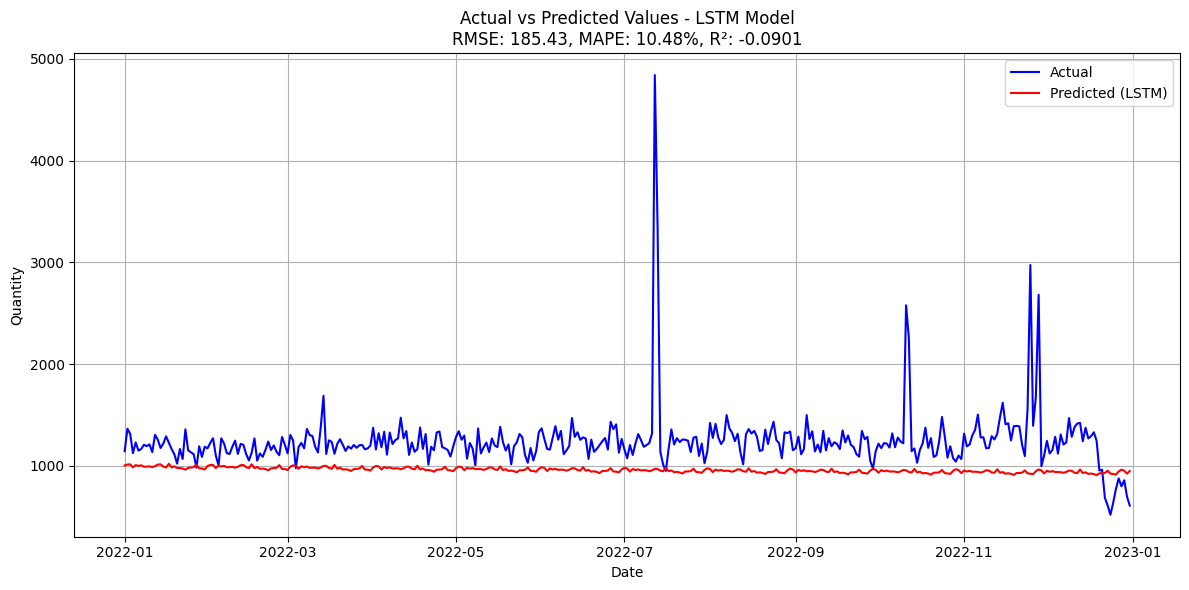

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Commented out Prophet import since it appears to be commented in your code
# from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Assuming daily_sales is a DataFrame with DatetimeIndex and 'Quantity' column

# Function to calculate MAPE (Mean Absolute Percentage Error)
def calculate_mape(y_true, y_pred):
    # Remove NaN values
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true, y_pred = y_true[mask], y_pred[mask]

    # Avoid division by zero by adding a small epsilon
    epsilon = 1e-10
    # Calculate absolute percentage error
    absolute_percentage_error = np.abs((y_true - y_pred) / (y_true + epsilon))
    # Return mean of absolute percentage error
    return np.mean(absolute_percentage_error) * 100

# Safe metric calculation functions that handle NaN values
def safe_rmse(y_true, y_pred):
    # Remove NaN values
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    if not np.any(mask):
        return np.nan  # Return NaN if all values are NaN
    return np.sqrt(mean_squared_error(y_true[mask], y_pred[mask]))

def safe_r2(y_true, y_pred):
    # Remove NaN values
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    if not np.any(mask) or len(y_true[mask]) <= 1:
        return np.nan  # Return NaN if all values are NaN or too few points
    return r2_score(y_true[mask], y_pred[mask])

# Data Splitting - Chronological split
train_data = daily_sales[daily_sales.index.year <= 2020]['Quantity']
validation_data = daily_sales[daily_sales.index.year == 2021]['Quantity']
test_data = daily_sales[daily_sales.index.year == 2022]['Quantity']

# Feature Engineering
def create_time_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week
    df['rolling_7'] = df['Quantity'].rolling(7).mean()
    return df.dropna()

ts_features = create_time_features(daily_sales)

# Create proper train/validation/test splits
X_train = ts_features[ts_features.index.year <= 2020].drop(columns=['Quantity'])
y_train = ts_features[ts_features.index.year <= 2020]['Quantity']

X_val = ts_features[ts_features.index.year == 2021].drop(columns=['Quantity'])
y_val = ts_features[ts_features.index.year == 2021]['Quantity']

X_test = ts_features[ts_features.index.year == 2022].drop(columns=['Quantity'])
y_test = ts_features[ts_features.index.year == 2022]['Quantity']

# 1. XGBoost Model
print("Training XGBoost model...")
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Evaluate on validation data
xgb_val_preds = xgb_model.predict(X_val)
xgb_val_rmse = safe_rmse(y_val, xgb_val_preds)
xgb_val_mape = calculate_mape(y_val, xgb_val_preds)
xgb_val_r2 = safe_r2(y_val, xgb_val_preds)
print(f"XGBoost Validation - RMSE: {xgb_val_rmse:.2f}, MAPE: {xgb_val_mape:.2f}%, R²: {xgb_val_r2:.4f}")

# Evaluate on test data
xgb_test_preds = xgb_model.predict(X_test)
xgb_test_rmse = safe_rmse(y_test, xgb_test_preds)
xgb_test_mape = calculate_mape(y_test, xgb_test_preds)
xgb_test_r2 = safe_r2(y_test, xgb_test_preds)
print(f"XGBoost Test - RMSE: {xgb_test_rmse:.2f}, MAPE: {xgb_test_mape:.2f}%, R²: {xgb_test_r2:.4f}")

# 2. SARIMA Model
print("Training SARIMA model...")
sarima_model = SARIMAX(train_data, order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_results = sarima_model.fit(disp=False)

# Evaluate on validation data
sarima_val_preds = sarima_results.get_forecast(steps=len(validation_data)).predicted_mean
sarima_val_rmse = safe_rmse(validation_data, sarima_val_preds)
sarima_val_mape = calculate_mape(validation_data, sarima_val_preds)
sarima_val_r2 = safe_r2(validation_data, sarima_val_preds)
print(f"SARIMA Validation - RMSE: {sarima_val_rmse:.2f}, MAPE: {sarima_val_mape:.2f}%, R²: {sarima_val_r2:.4f}")

# Evaluate on test data
# Fix: Calculate total forecast steps for validation + test
total_forecast_steps = len(validation_data) + len(test_data)
sarima_forecast = sarima_results.get_forecast(steps=total_forecast_steps).predicted_mean
# Extract just the test portion
sarima_test_preds = sarima_forecast[-len(test_data):]
sarima_test_rmse = safe_rmse(test_data, sarima_test_preds)
sarima_test_mape = calculate_mape(test_data, sarima_test_preds)
sarima_test_r2 = safe_r2(test_data, sarima_test_preds)
print(f"SARIMA Test - RMSE: {sarima_test_rmse:.2f}, MAPE: {sarima_test_mape:.2f}%, R²: {sarima_test_r2:.4f}")

# 3. Prophet Model - Uncomment if Prophet is installed

print("Training Prophet model...")
prophet_data = daily_sales.reset_index()[['date', 'Quantity']]
prophet_data.columns = ['ds', 'y']

# Split for Prophet
prophet_train = prophet_data[prophet_data['ds'].dt.year <= 2020]
prophet_val = prophet_data[prophet_data['ds'].dt.year == 2021]
prophet_test = prophet_data[prophet_data['ds'].dt.year == 2022]

# Train Prophet model
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
prophet_model.fit(prophet_train)

# Evaluate on validation data
future_val = prophet_model.make_future_dataframe(periods=len(prophet_val), freq='D')
forecast_val = prophet_model.predict(future_val)
prophet_val_preds = forecast_val.iloc[-len(prophet_val):]['yhat'].values
prophet_val_rmse = safe_rmse(prophet_val['y'].values, prophet_val_preds)
prophet_val_mape = calculate_mape(prophet_val['y'].values, prophet_val_preds)
prophet_val_r2 = safe_r2(prophet_val['y'].values, prophet_val_preds)
print(f"Prophet Validation - RMSE: {prophet_val_rmse:.2f}, MAPE: {prophet_val_mape:.2f}%, R²: {prophet_val_r2:.4f}")

# Evaluate on test data
future_test = prophet_model.make_future_dataframe(periods=len(prophet_val) + len(prophet_test), freq='D')
forecast_test = prophet_model.predict(future_test)
prophet_test_preds = forecast_test.iloc[-len(prophet_test):]['yhat'].values
prophet_test_rmse = safe_rmse(prophet_test['y'].values, prophet_test_preds)
prophet_test_mape = calculate_mape(prophet_test['y'].values, prophet_test_preds)
prophet_test_r2 = safe_r2(prophet_test['y'].values, prophet_test_preds)
print(f"Prophet Test - RMSE: {prophet_test_rmse:.2f}, MAPE: {prophet_test_mape:.2f}%, R²: {prophet_test_r2:.4f}")


# 4. LSTM Model
print("Training LSTM model...")
# LSTM Data Preparation function
def prepare_time_series_data(series, n_lag=90, n_seq=30):
    scaler = MinMaxScaler()
    series_scaled = scaler.fit_transform(series.values.reshape(-1, 1))
    X, y = [], []
    for i in range(len(series_scaled) - n_lag - n_seq + 1):
        X.append(series_scaled[i:(i + n_lag), 0])
        y.append(series_scaled[(i + n_lag):(i + n_lag + n_seq), 0])
    return np.array(X), np.array(y), scaler

# Prepare data for LSTM
X_train_lstm, y_train_lstm, scaler_lstm = prepare_time_series_data(train_data, 90, 30)
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))

# Build and train LSTM model
input_layer = Input(shape=(90, 1))
x = Bidirectional(LSTM(128, activation='relu', return_sequences=True))(input_layer)
x = Dropout(0.3)(x)
x = LSTM(128, activation='relu', return_sequences=True)(x)
x = Dropout(0.3)(x)
x = LSTM(64, activation='relu', return_sequences=False)(x)
x = Dropout(0.3)(x)
output_layer = Dense(30)(x)
lstm_model = Model(inputs=input_layer, outputs=output_layer)
lstm_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
lstm_model.fit(
    X_train_lstm,
    y_train_lstm,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10)]
)

# Evaluate LSTM on validation data
try:
    # We need to prepare validation data appropriately
    # This is tricky because we need a continuous sequence including training data
    combined_train_val = pd.concat([train_data, validation_data])
    X_val_lstm, y_val_lstm, _ = prepare_time_series_data(combined_train_val, 90, 30)
    X_val_lstm = X_val_lstm.reshape((X_val_lstm.shape[0], X_val_lstm.shape[1], 1))

    # Fix: Calculate proper indices for validation data
    # We want the last portion that corresponds to validation data predictions
    val_start_idx = len(train_data) - 90 - 30 + 1  # First index that includes validation data in prediction
    val_samples = len(validation_data) - 30 + 1    # Number of samples that predict validation data

    # Check if indices are valid
    if val_start_idx < 0 or val_start_idx + val_samples > len(X_val_lstm):
        print("Warning: Invalid indices for LSTM validation data. Adjusting...")
        val_start_idx = max(0, val_start_idx)
        val_samples = min(len(X_val_lstm) - val_start_idx, val_samples)

    if val_samples <= 0:
        raise ValueError("Not enough validation samples for LSTM")

    val_indices = list(range(val_start_idx, val_start_idx + val_samples))
    X_val_lstm_subset = X_val_lstm[val_indices]
    y_val_lstm_subset = y_val_lstm[val_indices]

    lstm_val_preds = lstm_model.predict(X_val_lstm_subset, verbose=0)

    # Check shapes before inverse transform
    if lstm_val_preds.shape[0] > 0 and y_val_lstm_subset.shape[0] > 0:
        # Inverse transform predictions and actual values for proper comparison
        val_preds_original = scaler_lstm.inverse_transform(lstm_val_preds.reshape(-1, 1)).flatten()
        val_actual_original = scaler_lstm.inverse_transform(y_val_lstm_subset.reshape(-1, 1)).flatten()

        # Check for NaN values
        if np.isnan(val_preds_original).any() or np.isnan(val_actual_original).any():
            print("Warning: NaN values detected in LSTM validation predictions or actual values.")
            # Filter out NaN values
            mask = ~np.isnan(val_actual_original) & ~np.isnan(val_preds_original)
            if np.any(mask):
                val_actual_original = val_actual_original[mask]
                val_preds_original = val_preds_original[mask]
            else:
                raise ValueError("All values are NaN in LSTM validation data")

        lstm_val_rmse = safe_rmse(val_actual_original, val_preds_original)
        lstm_val_mape = calculate_mape(val_actual_original, val_preds_original)
        lstm_val_r2 = safe_r2(val_actual_original, val_preds_original)
        print(f"LSTM Validation - RMSE: {lstm_val_rmse:.2f}, MAPE: {lstm_val_mape:.2f}%, R²: {lstm_val_r2:.4f}")
    else:
        raise ValueError("Empty arrays in LSTM validation data")
except Exception as e:
    print(f"Error in LSTM validation evaluation: {e}")
    # Set placeholder values
    lstm_val_rmse = np.nan
    lstm_val_mape = np.nan
    lstm_val_r2 = np.nan

# Evaluate LSTM on test data
try:
    # Similar approach for test data
    combined_train_val_test = pd.concat([train_data, validation_data, test_data])
    X_test_lstm, y_test_lstm, _ = prepare_time_series_data(combined_train_val_test, 90, 30)
    X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

    # Fix: Calculate proper indices for test data
    # We want the last portion that corresponds to test data predictions
    test_start_idx = len(train_data) + len(validation_data) - 90 - 30 + 1  # First index that includes test data in prediction
    test_samples = len(test_data) - 30 + 1    # Number of samples that predict test data

    # Check if indices are valid
    if test_start_idx < 0 or test_start_idx + test_samples > len(X_test_lstm):
        print("Warning: Invalid indices for LSTM test data. Adjusting...")
        test_start_idx = max(0, test_start_idx)
        test_samples = min(len(X_test_lstm) - test_start_idx, test_samples)

    if test_samples <= 0:
        raise ValueError("Not enough test samples for LSTM")

    test_indices = list(range(test_start_idx, test_start_idx + test_samples))
    X_test_lstm_subset = X_test_lstm[test_indices]
    y_test_lstm_subset = y_test_lstm[test_indices]

    lstm_test_preds = lstm_model.predict(X_test_lstm_subset, verbose=0)

    # Check shapes before inverse transform
    if lstm_test_preds.shape[0] > 0 and y_test_lstm_subset.shape[0] > 0:
        # Inverse transform
        test_preds_original = scaler_lstm.inverse_transform(lstm_test_preds.reshape(-1, 1)).flatten()
        test_actual_original = scaler_lstm.inverse_transform(y_test_lstm_subset.reshape(-1, 1)).flatten()

        # Check for NaN values
        if np.isnan(test_preds_original).any() or np.isnan(test_actual_original).any():
            print("Warning: NaN values detected in LSTM test predictions or actual values.")
            # Filter out NaN values
            mask = ~np.isnan(test_actual_original) & ~np.isnan(test_preds_original)
            if np.any(mask):
                test_actual_original = test_actual_original[mask]
                test_preds_original = test_preds_original[mask]
            else:
                raise ValueError("All values are NaN in LSTM test data")

        lstm_test_rmse = safe_rmse(test_actual_original, test_preds_original)
        lstm_test_mape = calculate_mape(test_actual_original, test_preds_original)
        lstm_test_r2 = safe_r2(test_actual_original, test_preds_original)
        print(f"LSTM Test - RMSE: {lstm_test_rmse:.2f}, MAPE: {lstm_test_mape:.2f}%, R²: {lstm_test_r2:.4f}")
    else:
        raise ValueError("Empty arrays in LSTM test data")
except Exception as e:
    print(f"Error in LSTM test evaluation: {e}")
    # Set placeholder values
    lstm_test_rmse = np.nan
    lstm_test_mape = np.nan
    lstm_test_r2 = np.nan

# Store validation results in dictionaries
val_rmse_results = {
    'XGBoost': xgb_val_rmse,
    'SARIMA': sarima_val_rmse,
    'Prophet': prophet_val_rmse,  # Uncomment if Prophet is used
}

val_mape_results = {
    'XGBoost': xgb_val_mape,
    'SARIMA': sarima_val_mape,
    'Prophet': prophet_val_mape,  # Uncomment if Prophet is used
}

val_r2_results = {
    'XGBoost': xgb_val_r2,
    'SARIMA': sarima_val_r2,
    'Prophet': prophet_val_r2,  # Uncomment if Prophet is used
}

# Only add LSTM results if they are valid
if not np.isnan(lstm_val_rmse):
    val_rmse_results['LSTM'] = lstm_val_rmse
    val_mape_results['LSTM'] = lstm_val_mape
    val_r2_results['LSTM'] = lstm_val_r2

# Filter out models with NaN validation metrics
valid_rmse_models = {k: v for k, v in val_rmse_results.items() if not np.isnan(v)}
valid_mape_models = {k: v for k, v in val_mape_results.items() if not np.isnan(v)}
valid_r2_models = {k: v for k, v in val_r2_results.items() if not np.isnan(v)}

# Find best model based on validation metrics
best_model_rmse = min(valid_rmse_models, key=valid_rmse_models.get) if valid_rmse_models else "None"
best_model_mape = min(valid_mape_models, key=valid_mape_models.get) if valid_mape_models else "None"
best_model_r2 = max(valid_r2_models, key=valid_r2_models.get) if valid_r2_models else "None"

print(f"\nBest Model (based on validation RMSE): {best_model_rmse} with RMSE: {valid_rmse_models.get(best_model_rmse, np.nan):.2f}")
print(f"Best Model (based on validation MAPE): {best_model_mape} with MAPE: {valid_mape_models.get(best_model_mape, np.nan):.2f}%")
print(f"Best Model (based on validation R²): {best_model_r2} with R²: {valid_r2_models.get(best_model_r2, np.nan):.4f}")

# Store test results
test_rmse_results = {
    'XGBoost': xgb_test_rmse,
    'SARIMA': sarima_test_rmse,
    'Prophet': prophet_test_rmse,  # Uncomment if Prophet is used
}

test_mape_results = {
    'XGBoost': xgb_test_mape,
    'SARIMA': sarima_test_mape,
    'Prophet': prophet_test_mape,  # Uncomment if Prophet is used
}

test_r2_results = {
    'XGBoost': xgb_test_r2,
    'SARIMA': sarima_test_r2,
    'Prophet': prophet_test_r2,  # Uncomment if Prophet is used
}

# Only add LSTM results if they are valid
if not np.isnan(lstm_test_rmse):
    test_rmse_results['LSTM'] = lstm_test_rmse
    test_mape_results['LSTM'] = lstm_test_mape
    test_r2_results['LSTM'] = lstm_test_r2

# Using RMSE as the primary metric for selecting the best model
best_model = best_model_rmse

print(f"\nTest metrics of best model ({best_model}):")
if best_model != "None":
    print(f"RMSE: {test_rmse_results.get(best_model, np.nan):.2f}")
    print(f"MAPE: {test_mape_results.get(best_model, np.nan):.2f}%")
    print(f"R²: {test_r2_results.get(best_model, np.nan):.4f}")
else:
    print("No valid model found.")

print("\nAll Test Results:")
for model in test_rmse_results.keys():
    if not np.isnan(test_rmse_results[model]):
        print(f"{model}: RMSE = {test_rmse_results[model]:.2f}, MAPE = {test_mape_results[model]:.2f}%, R² = {test_r2_results[model]:.4f}")

# Create a comparison DataFrame for easier analysis
comparison_data = {
    'Model': [],
    'RMSE': [],
    'MAPE (%)': [],
    'R²': []
}

for model in set(test_rmse_results.keys()):
    if not np.isnan(test_rmse_results.get(model, np.nan)):
        comparison_data['Model'].append(model)
        comparison_data['RMSE'].append(test_rmse_results[model])
        comparison_data['MAPE (%)'].append(test_mape_results[model])
        comparison_data['R²'].append(test_r2_results[model])

if comparison_data['Model']:
    comparison_df = pd.DataFrame(comparison_data)
    print("\nModel Comparison:")
    print(comparison_df.sort_values('RMSE'))
else:
    print("\nNo valid models to compare.")

# Store predictions for best model
best_predictions = None
if best_model == 'XGBoost':
    best_predictions = xgb_test_preds
elif best_model == 'SARIMA':
    best_predictions = sarima_test_preds
elif best_model == 'Prophet':  # Uncomment if Prophet is used
    best_predictions = prophet_test_preds
elif best_model == 'LSTM' and not np.isnan(lstm_test_rmse):
    best_predictions = test_preds_original

# Optional: Plot predictions vs actual for the best model
if best_model != "None" and best_predictions is not None:
    try:
        import matplotlib.pyplot as plt

        # Create a DataFrame for easier plotting
        results_df = pd.DataFrame({
            'Actual': test_data.values,
            'Predicted': best_predictions[:len(test_data)] if len(best_predictions) > len(test_data) else best_predictions
        }, index=test_data.index)

        plt.figure(figsize=(12, 6))
        plt.plot(results_df.index, results_df['Actual'], label='Actual', color='blue')
        plt.plot(results_df.index, results_df['Predicted'], label=f'Predicted ({best_model})', color='red')
        plt.title(f'Actual vs Predicted Values - {best_model} Model\nRMSE: {test_rmse_results[best_model]:.2f}, MAPE: {test_mape_results[best_model]:.2f}%, R²: {test_r2_results[best_model]:.4f}')
        plt.xlabel('Date')
        plt.ylabel('Quantity')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not create plot: {e}")
else:
    print("No valid model to plot results.")

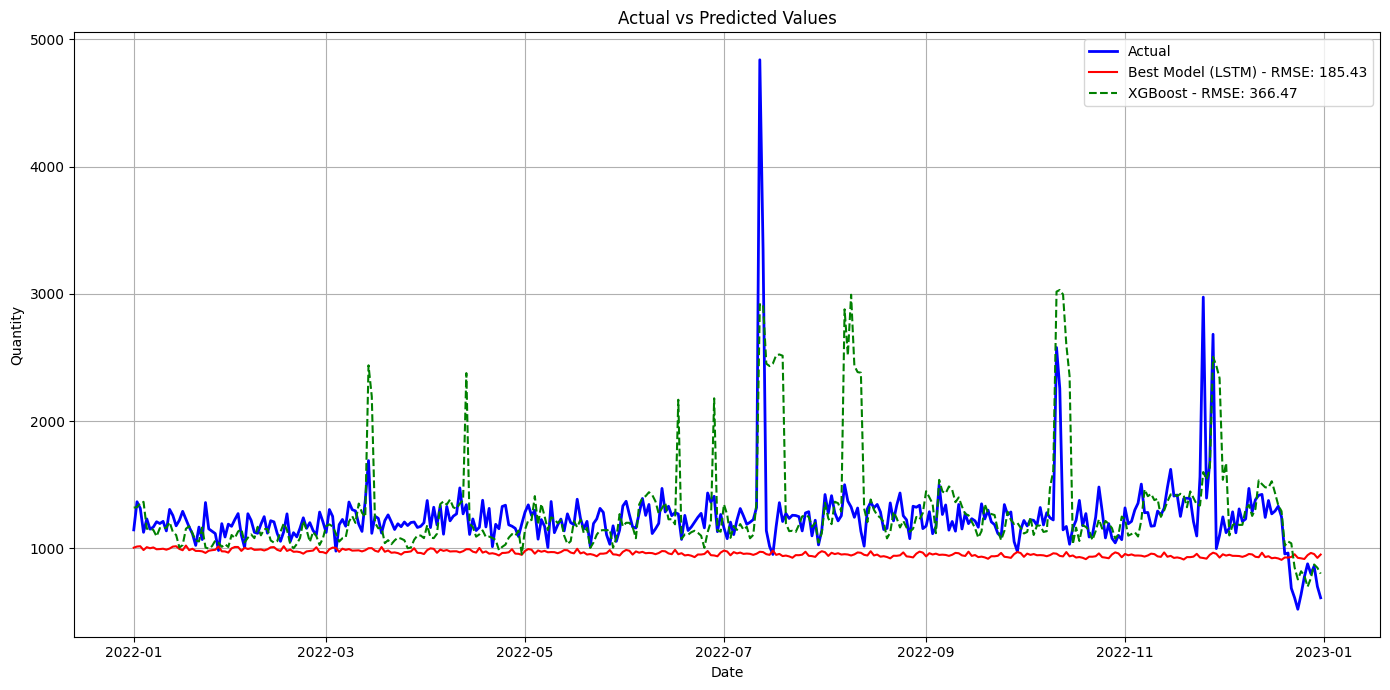

In [ ]:
# Optional: Plot predictions vs actual for the best model and XGBoost
if best_model != "None" and best_predictions is not None:
    try:
        import matplotlib.pyplot as plt

        # Create a DataFrame for easier plotting
        results_df = pd.DataFrame({
            'Actual': test_data.values,
            'Best Model': best_predictions[:len(test_data)] if len(best_predictions) > len(test_data) else best_predictions,
            'XGBoost': xgb_test_preds[:len(test_data)] if len(xgb_test_preds) > len(test_data) else xgb_test_preds
        }, index=test_data.index)

        plt.figure(figsize=(14, 7))
        plt.plot(results_df.index, results_df['Actual'], label='Actual', color='blue', linewidth=2)

        # Plot the best model (if not XGBoost)
        if best_model != 'XGBoost':
            plt.plot(results_df.index, results_df['Best Model'],
                    label=f'Best Model ({best_model}) - RMSE: {test_rmse_results[best_model]:.2f}',
                    color='red', linestyle='-')

        # Plot XGBoost predictions
        plt.plot(results_df.index, results_df['XGBoost'],
                label=f'XGBoost - RMSE: {xgb_test_rmse:.2f}',
                color='green', linestyle='--')

        plt.title('Actual vs Predicted Values')
        plt.xlabel('Date')
        plt.ylabel('Quantity')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not create plot: {e}")
else:
    print("No valid model to plot results.")

In [ ]:
# Optional: Plot predictions vs actual for the best model and XGBoost
if best_model != "None" and best_predictions is not None:
    try:
        import matplotlib.pyplot as plt

        # Create a DataFrame for easier plotting
        results_df = pd.DataFrame({
            'Actual': test_data.values,
            'Best Model': best_predictions[:len(test_data)] if len(best_predictions) > len(test_data) else best_predictions,
            'XGBoost': xgb_test_preds[:len(test_data)] if len(xgb_test_preds) > len(test_data) else xgb_test_preds
        }, index=test_data.index)

        plt.figure(figsize=(14, 7))
        plt.plot(results_df.index, results_df['Actual'], label='Actual', color='blue', linewidth=2)

        # Plot the best model (if not XGBoost)
        if best_model != 'XGBoost':
            plt.plot(results_df.index, results_df['Best Model'],
                    label=f'Best Model ({best_model}) - RMSE: {test_rmse_results[best_model]:.2f}',
                    color='red', linestyle='-')

        # Plot XGBoost predictions
        plt.plot(results_df.index, results_df['XGBoost'],
                label=f'XGBoost - RMSE: {xgb_test_rmse:.2f}',
                color='green', linestyle='--')

        plt.title('Actual vs Predicted Values')
        plt.xlabel('Date')
        plt.ylabel('Quantity')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not create plot: {e}")
else:
    print("No valid model to plot results.")


Generating training predictions plot...


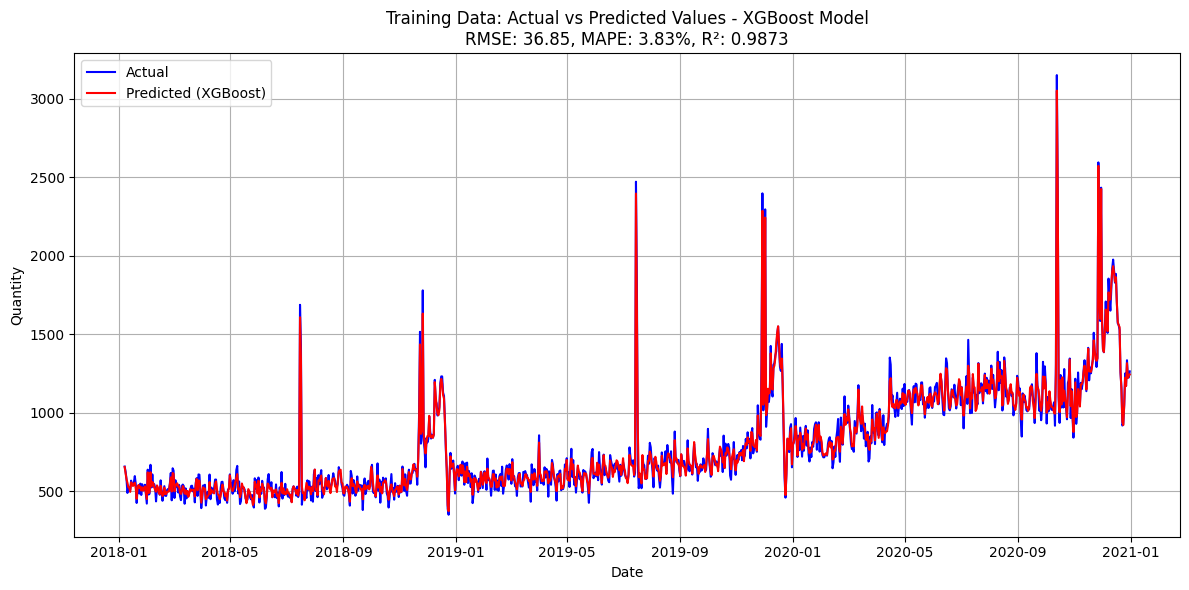

XGBoost Training - RMSE: 36.85, MAPE: 3.83%, R²: 0.9873


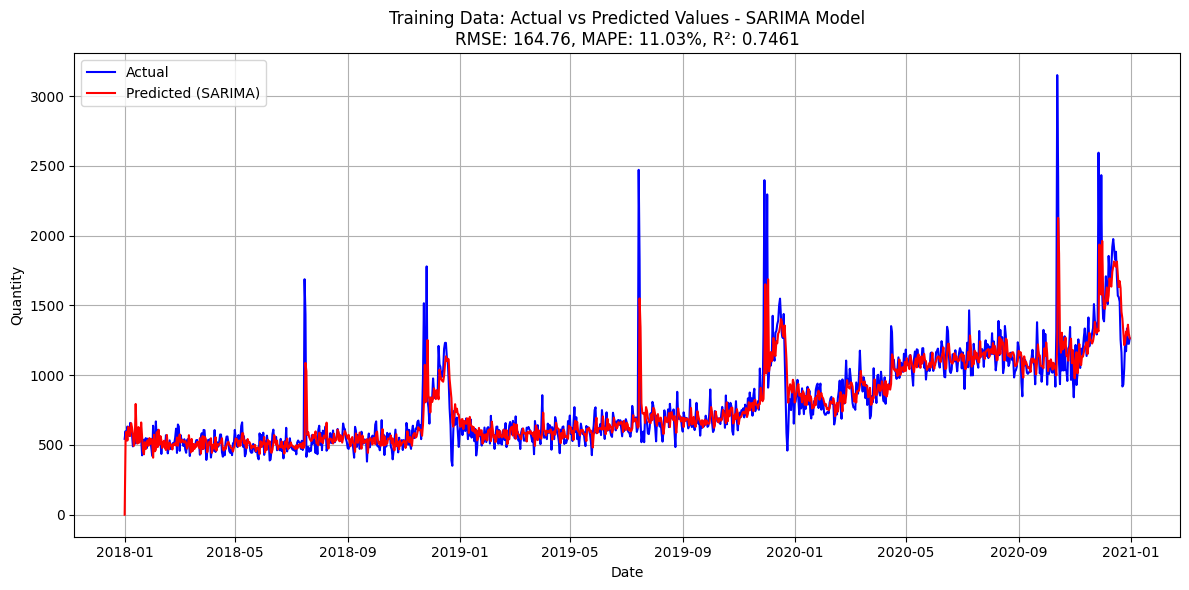

SARIMA Training - RMSE: 164.76, MAPE: 11.03%, R²: 0.7461


<ipython-input-40-fecb757ee8e1>:64: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  prophet_train_dates = prophet_train['ds'].dt.to_pydatetime()


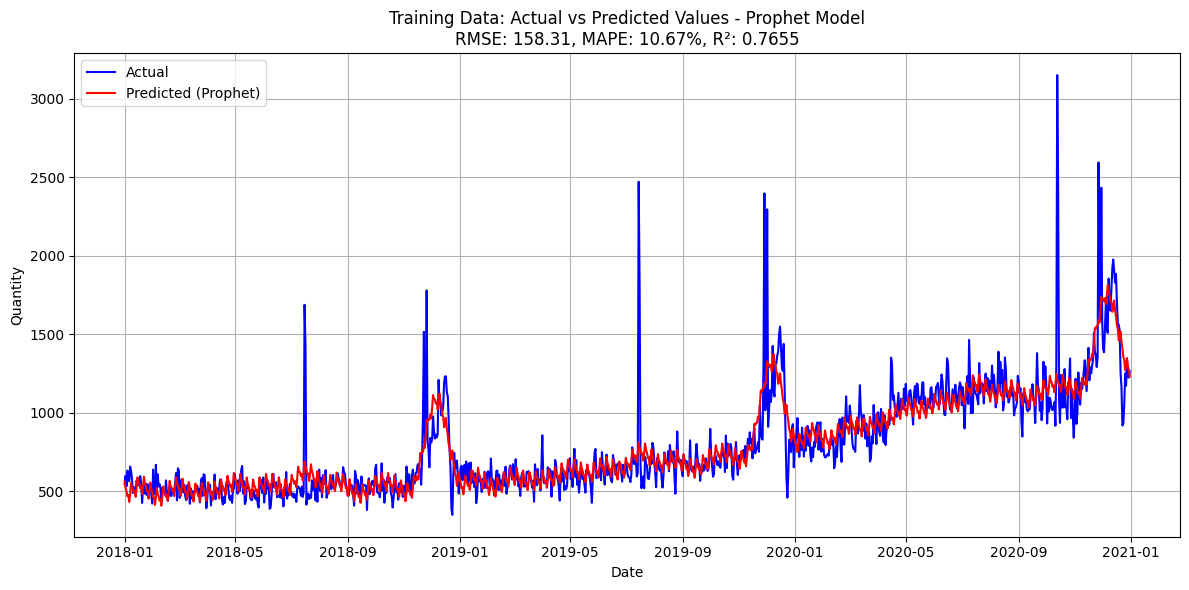

Prophet Training - RMSE: 158.31, MAPE: 10.67%, R²: 0.7655


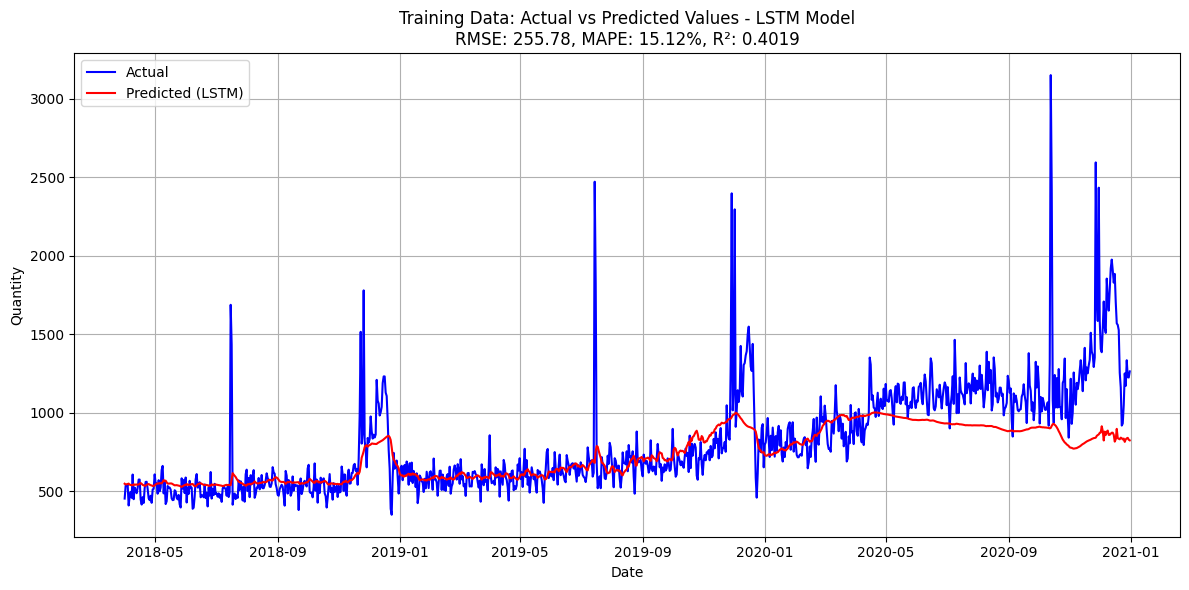

LSTM Training - RMSE: 255.78, MAPE: 15.12%, R²: 0.4019


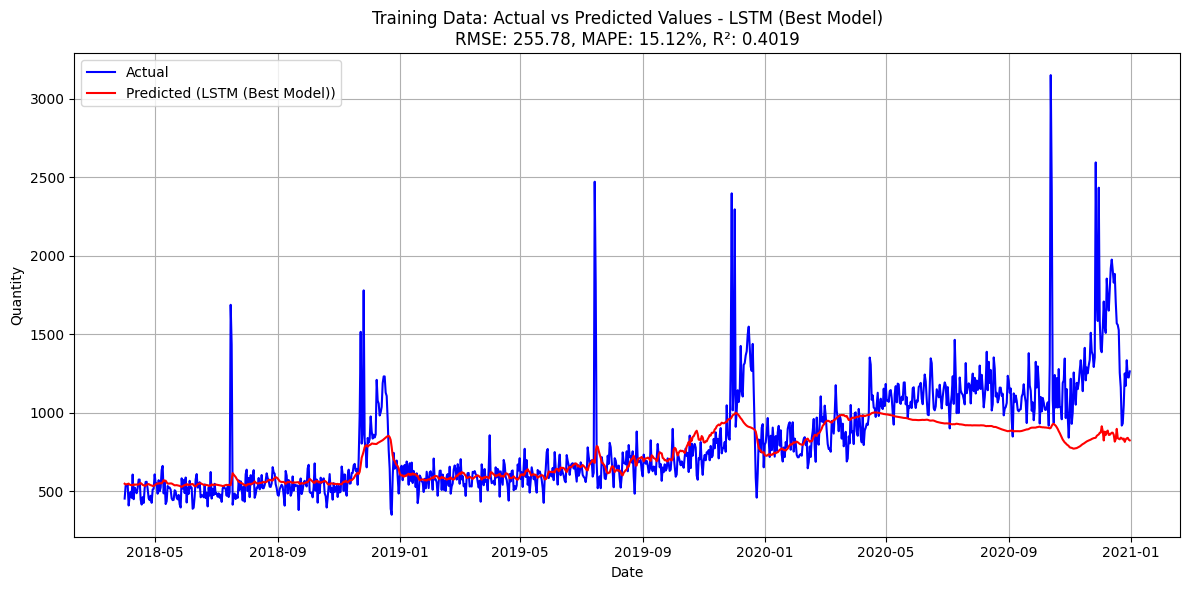


Training Data Model Comparison:
     Model        RMSE   MAPE (%)        R²
0  XGBoost   36.848061   3.826466  0.987337
2  Prophet  158.314791  10.667713  0.765536
1   SARIMA  164.755671  11.029750  0.746070
3     LSTM  255.784843  15.120034  0.401902


In [ ]:
# Generate training predictions for the best model
print("\nGenerating training predictions plot...")

# Define function to create training plots for any model
def plot_training_predictions(model_name, y_true, y_pred, title=None):
    """
    Plot actual vs predicted values for training data.

    Parameters:
    model_name (str): Name of the model
    y_true (Series): Actual values with DatetimeIndex
    y_pred (array): Predicted values
    title (str, optional): Custom title for the plot
    """
    # Create a DataFrame for easier plotting
    results_df = pd.DataFrame({
        'Actual': y_true,
        'Predicted': y_pred[:len(y_true)] if len(y_pred) > len(y_true) else y_pred
    }, index=y_true.index)

    # Calculate metrics
    train_rmse = safe_rmse(y_true, y_pred)
    train_mape = calculate_mape(y_true, y_pred)
    train_r2 = safe_r2(y_true, y_pred)

    # Create plot
    plt.figure(figsize=(12, 6))
    plt.plot(results_df.index, results_df['Actual'], label='Actual', color='blue')
    plt.plot(results_df.index, results_df['Predicted'], label=f'Predicted ({model_name})', color='red')

    # Set title
    if title:
        plt.title(title)
    else:
        plt.title(f'Training Data: Actual vs Predicted Values - {model_name} Model\nRMSE: {train_rmse:.2f}, MAPE: {train_mape:.2f}%, R²: {train_r2:.4f}')

    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return train_rmse, train_mape, train_r2

# Generate predictions for each model on training data
# 1. XGBoost
xgb_train_preds = xgb_model.predict(X_train)
xgb_train_rmse, xgb_train_mape, xgb_train_r2 = plot_training_predictions('XGBoost', y_train, xgb_train_preds)
print(f"XGBoost Training - RMSE: {xgb_train_rmse:.2f}, MAPE: {xgb_train_mape:.2f}%, R²: {xgb_train_r2:.4f}")

# 2. SARIMA
# For SARIMA, we need to get in-sample predictions
sarima_train_preds = sarima_results.get_prediction(start=0, end=len(train_data)-1).predicted_mean
sarima_train_rmse, sarima_train_mape, sarima_train_r2 = plot_training_predictions('SARIMA', train_data, sarima_train_preds)
print(f"SARIMA Training - RMSE: {sarima_train_rmse:.2f}, MAPE: {sarima_train_mape:.2f}%, R²: {sarima_train_r2:.4f}")

# 3. Prophet
# For Prophet, we need to get predictions for the training period
prophet_train_forecast = prophet_model.predict(prophet_train)
prophet_train_preds = prophet_train_forecast['yhat'].values
# Convert index to match with original training data
prophet_train_actual = prophet_train['y'].values
prophet_train_dates = prophet_train['ds'].dt.to_pydatetime()
train_data_prophet = pd.Series(prophet_train_actual, index=prophet_train_dates)
prophet_train_rmse, prophet_train_mape, prophet_train_r2 = plot_training_predictions('Prophet', train_data_prophet, prophet_train_preds)
print(f"Prophet Training - RMSE: {prophet_train_rmse:.2f}, MAPE: {prophet_train_mape:.2f}%, R²: {prophet_train_r2:.4f}")

# 4. LSTM
# For LSTM, we need to carefully handle the shifted predictions
try:
    # Prepare predictions from the training data
    lstm_train_preds = lstm_model.predict(X_train_lstm, verbose=0)

    # We need to map these back to the original dates
    # First, we need to get the original dates for our training data
    train_dates = train_data.index

    # The predictions are shifted by n_lag time steps (90)
    # And each prediction is for n_seq time steps (30)
    # So we need to map each prediction to the right dates

    # Create empty series to hold our predictions
    lstm_train_predictions = pd.Series(index=train_dates, dtype=float)

    # For each training sample
    for i in range(len(X_train_lstm)):
        # Get prediction dates (shifted by n_lag)
        pred_dates = train_dates[i+90:i+90+30]

        # Skip if we're out of bounds
        if len(pred_dates) == 0:
            continue

        # Get the predictions for this sample
        preds = scaler_lstm.inverse_transform(lstm_train_preds[i].reshape(-1, 1)).flatten()

        # Assign predictions to dates
        for j, date in enumerate(pred_dates):
            if j >= len(preds):
                break
            lstm_train_predictions[date] = preds[j]

    # Remove NA values
    lstm_train_predictions = lstm_train_predictions.dropna()

    # Get actual values for the same dates
    lstm_train_actual = train_data.loc[lstm_train_predictions.index]

    # Plot
    lstm_train_rmse, lstm_train_mape, lstm_train_r2 = plot_training_predictions(
        'LSTM',
        lstm_train_actual,
        lstm_train_predictions.values
    )
    print(f"LSTM Training - RMSE: {lstm_train_rmse:.2f}, MAPE: {lstm_train_mape:.2f}%, R²: {lstm_train_r2:.4f}")

except Exception as e:
    print(f"Error in LSTM training evaluation: {e}")

# Plot for the best model with a special title
if best_model == 'XGBoost':
    plot_training_predictions(
        'XGBoost (Best Model)',
        y_train,
        xgb_train_preds,
        title=f'Training Data: Actual vs Predicted Values - XGBoost (Best Model)\nRMSE: {xgb_train_rmse:.2f}, MAPE: {xgb_train_mape:.2f}%, R²: {xgb_train_r2:.4f}'
    )
elif best_model == 'SARIMA':
    plot_training_predictions(
        'SARIMA (Best Model)',
        train_data,
        sarima_train_preds,
        title=f'Training Data: Actual vs Predicted Values - SARIMA (Best Model)\nRMSE: {sarima_train_rmse:.2f}, MAPE: {sarima_train_mape:.2f}%, R²: {sarima_train_r2:.4f}'
    )
elif best_model == 'Prophet':
    plot_training_predictions(
        'Prophet (Best Model)',
        train_data_prophet,
        prophet_train_preds,
        title=f'Training Data: Actual vs Predicted Values - Prophet (Best Model)\nRMSE: {prophet_train_rmse:.2f}, MAPE: {prophet_train_mape:.2f}%, R²: {prophet_train_r2:.4f}'
    )
elif best_model == 'LSTM' and 'lstm_train_rmse' in locals():
    plot_training_predictions(
        'LSTM (Best Model)',
        lstm_train_actual,
        lstm_train_predictions.values,
        title=f'Training Data: Actual vs Predicted Values - LSTM (Best Model)\nRMSE: {lstm_train_rmse:.2f}, MAPE: {lstm_train_mape:.2f}%, R²: {lstm_train_r2:.4f}'
    )

# Create a comparison DataFrame for training results
training_comparison_data = {
    'Model': [],
    'RMSE': [],
    'MAPE (%)': [],
    'R²': []
}

# Add results for each model if they exist
if 'xgb_train_rmse' in locals():
    training_comparison_data['Model'].append('XGBoost')
    training_comparison_data['RMSE'].append(xgb_train_rmse)
    training_comparison_data['MAPE (%)'].append(xgb_train_mape)
    training_comparison_data['R²'].append(xgb_train_r2)

if 'sarima_train_rmse' in locals():
    training_comparison_data['Model'].append('SARIMA')
    training_comparison_data['RMSE'].append(sarima_train_rmse)
    training_comparison_data['MAPE (%)'].append(sarima_train_mape)
    training_comparison_data['R²'].append(sarima_train_r2)

if 'prophet_train_rmse' in locals():
    training_comparison_data['Model'].append('Prophet')
    training_comparison_data['RMSE'].append(prophet_train_rmse)
    training_comparison_data['MAPE (%)'].append(prophet_train_mape)
    training_comparison_data['R²'].append(prophet_train_r2)

if 'lstm_train_rmse' in locals():
    training_comparison_data['Model'].append('LSTM')
    training_comparison_data['RMSE'].append(lstm_train_rmse)
    training_comparison_data['MAPE (%)'].append(lstm_train_mape)
    training_comparison_data['R²'].append(lstm_train_r2)

# Create and display comparison table
if training_comparison_data['Model']:
    train_comparison_df = pd.DataFrame(training_comparison_data)
    print("\nTraining Data Model Comparison:")
    print(train_comparison_df.sort_values('RMSE'))
else:
    print("\nNo valid models to compare for training data.")

## Business Recomendation

In [ ]:
import tensorflow as tf
# Set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


# Calculate total units sold in 2022 (real data)
actual_2022_sales = test_data.sum()

# Calculate total units sold in 2021
total_units_2021 = validation_data.sum()

print("\n===== SALES PREDICTION SUMMARY =====")
print(f"Actual 2022 Sales: {actual_2022_sales:.2f}")
print(f"Actual 2021 Sales: {total_units_2021:.2f}")

# ------- XGBoost Predictions -------
# Extract and align XGBoost predictions with test data
xgb_pred_val = xgb_test_preds
# Make sure predictions array length matches test data
if len(xgb_pred_val) > len(test_data):
    xgb_pred_val = xgb_pred_val[:len(test_data)]
elif len(xgb_pred_val) < len(test_data):
    # Pad with NaN if needed
    padding = np.full(len(test_data) - len(xgb_pred_val), np.nan)
    xgb_pred_val = np.concatenate([xgb_pred_val, padding])

# Create a DataFrame with predictions
xgb_forecast_df = pd.DataFrame(
    data={'Forecast': xgb_pred_val},
    index=test_data.index[:len(xgb_pred_val)]
)
predicted_2022_sales_xgboost = xgb_forecast_df['Forecast'].sum()

# ------- SARIMA Predictions -------
# Extract and align SARIMA predictions with test data
sarima_pred_val = sarima_test_preds
# Make sure predictions array length matches test data
if len(sarima_pred_val) > len(test_data):
    sarima_pred_val = sarima_pred_val[:len(test_data)]
elif len(sarima_pred_val) < len(test_data):
    # Pad with NaN if needed
    padding = np.full(len(test_data) - len(sarima_pred_val), np.nan)
    sarima_pred_val = np.concatenate([sarima_pred_val, padding])

# Create a DataFrame with predictions
sarima_forecast_df = pd.DataFrame(
    data={'Forecast': sarima_pred_val},
    index=test_data.index[:len(sarima_pred_val)]
)
predicted_2022_sales_sarima = sarima_forecast_df['Forecast'].sum()

# ------- LSTM Predictions -------
# Check if LSTM predictions are available and valid
if 'test_preds_original' in locals() and isinstance(test_preds_original, np.ndarray) and len(test_preds_original) > 0:
    # The LSTM predictions might require special handling

    # First, check if there are any NaN values
    if np.isnan(test_preds_original).any():
        print("Warning: NaN values in LSTM predictions were detected and will be removed.")
        test_preds_original = test_preds_original[~np.isnan(test_preds_original)]

    # Create a DataFrame with the LSTM predictions
    # We need to be careful with the index alignment
    if len(test_preds_original) <= len(test_data):
        # If predictions are fewer than test data points
        lstm_dates = test_data.index[-len(test_preds_original):]
    else:
        # If predictions are more than test data points
        lstm_dates = test_data.index
        test_preds_original = test_preds_original[:len(lstm_dates)]

    lstm_forecast_df = pd.DataFrame(
        data={'Forecast': test_preds_original},
        index=lstm_dates
    )

    # Calculate the sum of predictions
    predicted_2022_sales_lstm = lstm_forecast_df['Forecast'].sum()
    print(f"LSTM Forecast Shape: {lstm_forecast_df.shape}")
else:
    print("No valid LSTM predictions available.")
    predicted_2022_sales_lstm = np.nan
    lstm_forecast_df = pd.DataFrame({'Forecast': []})

# ------- Prophet Predictions -------

prophet_test_pred_val = prophet_test_preds
if len(prophet_test_pred_val) > len(test_data):
    prophet_test_pred_val = prophet_test_pred_val[:len(test_data)]
elif len(prophet_test_pred_val) < len(test_data):
    padding = np.full(len(test_data) - len(prophet_test_pred_val), np.nan)
    prophet_test_pred_val = np.concatenate([prophet_test_pred_val, padding])

prophet_forecast_df = pd.DataFrame(
    data={'Forecast': prophet_test_pred_val},
    index=test_data.index[:len(prophet_test_pred_val)]
)
predicted_2022_sales_prophet = prophet_forecast_df['Forecast'].sum()

# Set to NaN as Prophet is not being used
#predicted_2022_sales_prophet = np.nan

# ------- Calculate Indices (2022 vs 2021) -------
index_2022_actual = ((actual_2022_sales / total_units_2021) * 100).round(2)
index_2022_xgboost = ((predicted_2022_sales_xgboost / total_units_2021) * 100).round(2)
index_2022_sarima = ((predicted_2022_sales_sarima / total_units_2021) * 100).round(2)
index_2022_lstm = ((predicted_2022_sales_lstm / total_units_2021) * 100).round(2) if not np.isnan(predicted_2022_sales_lstm) else np.nan
index_2022_prophet = ((predicted_2022_sales_prophet / total_units_2021) * 100).round(2) if not np.isnan(predicted_2022_sales_prophet) else np.nan

# ------- Create Summary DataFrame -------
summary_data = {
    'Source': ['ACTUAL 2022', 'XGBoost', 'SARIMA', 'LSTM', 'Prophet'],
    'Total Units Sold': [
        actual_2022_sales,
        predicted_2022_sales_xgboost,
        predicted_2022_sales_sarima,
        predicted_2022_sales_lstm,
        predicted_2022_sales_prophet
    ],
    'Index (vs 2021)': [
        index_2022_actual,
        index_2022_xgboost,
        index_2022_sarima,
        index_2022_lstm,
        index_2022_prophet
    ]
}

# Create the summary DataFrame and drop rows with NaN values
summary_df = pd.DataFrame(summary_data)
summary_df_clean = summary_df.dropna()

# Print detailed prediction information
print("\nDetailed Prediction Results:")
print(f"XGBoost: {predicted_2022_sales_xgboost:.2f} units (Index: {index_2022_xgboost})")
print(f"SARIMA: {predicted_2022_sales_sarima:.2f} units (Index: {index_2022_sarima})")
if not np.isnan(predicted_2022_sales_lstm):
    print(f"LSTM: {predicted_2022_sales_lstm:.2f} units (Index: {index_2022_lstm})")
else:
    print("LSTM: No valid predictions")
if not np.isnan(predicted_2022_sales_prophet):
    print(f"Prophet: {predicted_2022_sales_prophet:.2f} units (Index: {index_2022_prophet})")
else:
    print("Prophet: Not used")

# Display the summary table
print("\nSummary of 2022 Sales Predictions (complete):")
print(summary_df)

print("\nSummary of 2022 Sales Predictions (valid models only):")
print(summary_df_clean)



===== SALES PREDICTION SUMMARY =====
Actual 2022 Sales: 453372.00
Actual 2021 Sales: 468197.00
LSTM Forecast Shape: (365, 1)

Detailed Prediction Results:
XGBoost: 470844.06 units (Index: 100.57)
SARIMA: 633045.15 units (Index: 135.21)
LSTM: 350496.75 units (Index: 74.86)
Prophet: 690394.78 units (Index: 147.46)

Summary of 2022 Sales Predictions (complete):
        Source  Total Units Sold  Index (vs 2021)
0  ACTUAL 2022     453372.000000            96.83
1      XGBoost     470844.062500           100.57
2       SARIMA     633045.154070           135.21
3         LSTM     350496.750000            74.86
4      Prophet     690394.776478           147.46

Summary of 2022 Sales Predictions (valid models only):
        Source  Total Units Sold  Index (vs 2021)
0  ACTUAL 2022     453372.000000            96.83
1      XGBoost     470844.062500           100.57
2       SARIMA     633045.154070           135.21
3         LSTM     350496.750000            74.86
4      Prophet     690394.776478